#### Summary: 
In this notebook we perform enrichment analyses for eQTLs in cREs linked to genes (that select the same target gene). These analyses are done on sets of links binned by distances, as well as sets of significant links found by multiple methods. 

- Significant sets: all links within distance bins, subsampled down to match size of background set if larger
- Background sets: all links within same distance bins, subsampled down to match size of significant set if larger
- After everything removes thresholded files to save space

# 1. Basic Preparation

In [1]:
# Import necessary libraries
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(cicero))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

suppressMessages(library(parallel))

In [2]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', '#F5DE6C')

In [3]:
# Define names and colors for link methods
link_methods <- c('SMORES', 'ABC', 'Cicero')
link_colors <- c('#E151A7', '#1D8BDF', '#DEBE1D')
names(link_colors) <- link_methods

# Define overlap sets and colors
link_sets <- c('hm_abc_cic', 'hm_abc', 'hm_cic', 'abc_cic', 'hm', 'abc', 'cic')
overlap_colors <- c('#000000', #All 3 links (black)
                    '#7F6EC3', #HM + ABC (orange)                    
                    '#E08862', #HM + Cicero (purple)
                    '#7EA57E', #ABC + Cicero (green)
                    '#E151A7', #HM (pink)
                    '#1D8BDF', #ABC (blue)
                    '#DEBE1D') #Cicero (yellow)
names(overlap_colors) <- link_sets

In [4]:
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000')

In [5]:
# disable scientific notation for the filepath names of larger distances
options(scipen = 999)
set.seed(8)

### Important file paths

In [6]:
#significant links are in one file now
# sig links (w header) = links_dir + celltype + links_suffix
links_dir <- '/path/to/3methods/combined/files'
links_suffix <- '_all_methods_links.wHeader.bedpe'
bg_dir <- '/dir/with/merged/all/methods/background/links'

In [7]:
#background links are in different places 
# SMORES links (CP cut) = hm_prefix + celltype + hm_suffix
hm_prefix <- '/path/to/SMORES/background/links/'
hm_suffix <- '_all_CP_links.bedpe'

# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/path/to/reprocessed/ABC/background/links/'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/path/to/reprocessed/Cicero/background/links'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [8]:
outdir <- '/path/to/save/outputs/to'

### Define necessary reference files

In [9]:
# read in the gene coords ref file
ref_df <- read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)

# 2. Process the eQTL data

Obtain the eQTL data you want to use as the "ground truth" set to compare enrichment in. The eQTL data should be only significant results, have SNPs in star-0 hg38 coords and be in a bed file with the following information: `chr#	start	end	rsID	pvalue	effect	qvalue	gene_name`. In this study we use eQTL data from bulk pancreatic islets generated by the InsPIRE consortium -- [Vinuela et al. (2020)](https://www.nature.com/articles/s41467-020-18581-8).

In [10]:
# Input file
eqtl_dir <- '/dir/with/eqtl/data'
eqtl_fp  <- file.path(eqtl_dir,'sig_start0_eQTL.bed')

# 3. eQTL enrichment thresholded by distance (separate method sets)

## 3a. Threshold link sets by distances, output as bedpe files

### Functions

In [11]:
### Function to calculate link distances from a bedpe style dataframe row
calc_link_distance <- function(link_df_row){
    CRE_start <- as.integer(link_df_row[2])
    CRE_end <- as.integer(link_df_row[3])
    gene_start <- as.integer(link_df_row[5])
    CRE_center <- CRE_start + (CRE_end - CRE_start)/2
    distance <- abs(CRE_center - gene_start)
    return(distance)
}


### Function which uses min and max distances (as set in distance_bins) to create groups of links
threshold_links_bins <- function(df, distance_bin, outdir, prefix){
    #separate distance_bin string into min and max distance
    min_dist <- as.numeric(str_split(distance_bin, '-')[[1]][1])
    max_dist <- as.numeric(str_split(distance_bin, '-')[[1]][2])
    
    #read in links bedpe and calculate distances
    df$distance <- unlist(apply(df, 1, calc_link_distance))
    fin_col <- dim(df)[2]
    
    #cut down links by min and max distances and write file
    df_cut <- df[df$distance <= max_dist & df$distance >= min_dist,-fin_col]
    out_fp <- file.path(outdir, sprintf('%s_links_dist_bin_%s.bedpe', prefix, distance_bin))
    write.table(df_cut, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
}

### Run functions to threshold links

In [12]:
dist_outdir <- file.path(outdir, 'cut_links')
dir.create(dist_outdir, showWarnings=FALSE)

In [13]:
# Threshold all significant method links (get from overall df)
tic()
for (celltype in celltypes){
    #make celltype specific outdir
    ct_outdir <- file.path(dist_outdir,paste0(celltype,'_sig'))
    dir.create(ct_outdir, showWarnings=FALSE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract method links AND remove annoying columns
    hm_links <- subset(sig_links, !is.na(hm_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str))
    abc_links <- subset(sig_links, !is.na(abc_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str))
    cic_links <- subset(sig_links, !is.na(cic_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str))

    for(dist in distance_bins){
        threshold_links_bins(hm_links, dist, ct_outdir,'SMORES')
        threshold_links_bins(abc_links, dist, ct_outdir,'ABC')
        threshold_links_bins(cic_links, dist, ct_outdir,'Cicero')
    }
}
toc()

203.282 sec elapsed


In [14]:
# Threshold all background links
tic()
for (celltype in celltypes){
    #make celltype specific outdir
    ct_outdir <- file.path(dist_outdir,paste0(celltype,'_bg'))
    dir.create(ct_outdir, showWarnings=FALSE)
    
    #read in different background links sets
    hm_bg_links <- read.table(paste0(hm_prefix, celltype, hm_suffix), sep='\t')
    abc_bg_links <- read.table(paste0(abc_bg_dir, celltype, abc_bg_suffix), sep='\t')
    cic_bg_links <- read.table(paste0(cic_bg_dir, celltype, cic_bg_suffix), sep='\t')
    
    for(dist in distance_bins){
        threshold_links_bins(hm_bg_links, dist, ct_outdir,'SMORES')
        threshold_links_bins(abc_bg_links, dist, ct_outdir,'ABC')
        threshold_links_bins(cic_bg_links, dist, ct_outdir,'Cicero')
    }
}
toc()

4142.482 sec elapsed


## 3b. Select for links that overlap an eQTL (in the CRE)
Do this for both significant and non-significant links (background), then can use a method similar to the compare connections wrapper function, but will also need a custom function for quantifying if eQTL gene matches the link gene.

### Functions

In [15]:
### Select for all links which have CREs that overlap an islet eQTL (for ANY input link bedpe)
### Save relevant eQTL information too (target gene, etc)
get_linkedCRE_eQTL_overlaps <- function(links_fp, eqtl_fp, out_fp){
    # Use bedtools intersect 
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb > %s', links_fp, eqtl_fp, out_fp)
    system(cmd)
    cmd2 <- sprintf('gzip %s', out_fp)
    system(cmd2)
}

### Generate eQTL overlapping links sets (gzip output files to save space)

In [16]:
# Output directories
eqtl_outdir <- file.path(outdir,'distance_binned_overlaps')
dir.create(eqtl_outdir, showWarnings=FALSE)
eqtl_inputs <- file.path(eqtl_outdir, 'inputs')
dir.create(eqtl_inputs, showWarnings=FALSE)

In [17]:
# Loop through all sig links from all 3 methods
tic()
for (celltype in celltypes){
    # make output directory for cell type
    ct_indir <- file.path(dist_outdir,paste0(celltype,'_sig'))
    ct_outdir <- file.path(eqtl_inputs,paste0(celltype,'_sig'))
    dir.create(ct_outdir,showWarnings=FALSE)

    # loop through distances
    for (dist in distance_bins){
        hm_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'SMORES', dist))
        hm_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'SMORES', dist))
        get_linkedCRE_eQTL_overlaps(hm_fp, eqtl_fp, hm_out_fp)
        
        abc_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'ABC', dist))
        abc_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'ABC', dist))
        get_linkedCRE_eQTL_overlaps(abc_fp, eqtl_fp, abc_out_fp)
        
        cic_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'Cicero', dist))
        cic_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'Cicero', dist))
        get_linkedCRE_eQTL_overlaps(cic_fp, eqtl_fp, cic_out_fp)
    }
}
toc()

285.8 sec elapsed


In [18]:
# Loop through all bg links from all 3 methods
tic()
for (celltype in celltypes){
    # make output directory for cell type
    ct_indir <- file.path(dist_outdir,paste0(celltype,'_bg'))
    ct_outdir <- file.path(eqtl_inputs,paste0(celltype,'_bg'))
    dir.create(ct_outdir,showWarnings=FALSE)

    # loop through distances
    for (dist in distance_bins){
        hm_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'SMORES', dist))
        hm_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'SMORES', dist))
        get_linkedCRE_eQTL_overlaps(hm_fp, eqtl_fp, hm_out_fp)
        
        abc_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'ABC', dist))
        abc_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'ABC', dist))
        get_linkedCRE_eQTL_overlaps(abc_fp, eqtl_fp, abc_out_fp)
        
        cic_fp <- file.path(ct_indir, sprintf('%s_links_dist_bin_%s.bedpe', 'Cicero', dist))
        cic_out_fp <- file.path(ct_outdir,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed', 'Cicero', dist))
        get_linkedCRE_eQTL_overlaps(cic_fp, eqtl_fp, cic_out_fp)
    }
}
toc()

563.032 sec elapsed


## 3c. Compare concordance between links and eQTLs for comparable sets (signif and nonsignif)

### Functions

In [19]:
### Function to compare genes between sig and eQTLs
compare_genes <- function(df_row){
    return(df_row[['link_gene']] == df_row[['eqtl_gene']])
}


### Function that the permutations can call to subsample a bg links set and calculate gene concordance
get_links_eqtl_concordance <- function(x, links_df, num_links){
    links_df_fin <- links_df[sample(dim(links_df)[1], num_links),]  
    links_df_fin$gene_match <- unlist(apply(links_df_fin, 1, compare_genes))
    return(sum(links_df_fin$gene_match))
}

In [20]:
### Get the number of concordant eQTLs in linked CREs for significant and background links
### N dictates how many permutations to do (permutes whichever set is larger)

get_eqtl_concordance <- function(signif_links_fp, all_links_fp, N=100){
    # Check if we have links to read in before proceeding
    if (file.size(signif_links_fp) == 0L){
        print(paste('No links in the file', signif_links_fp))
        return(c(NA,NA,NA,NA,NA,NA))
    } else if (file.size(all_links_fp) == 0L){
        print(paste('No links in the file', all_links_fp))
        return(c(NA,NA,NA,NA,NA,NA))        
    } else {
        # Read in files, noting if they have a header or not
        cols <- c('CRE_chr','CRE_start','CRE_end','gene_chr','gene_start','gene_end','link_gene','score',
                  'eqtl_chr','eqtl_start','eqtl_end','rsID','pvalue','effect','std_error','eqtl_gene')
        signif_links <- read.table(signif_links_fp, sep='\t', header=FALSE)
        colnames(signif_links) <- cols
        all_links = read.table(all_links_fp, sep='\t', header=FALSE)
        colnames(all_links) <- cols

        # Remove any significant links from the background (some bg files have them still) -- should I?
        signif_links$link <- paste(paste(signif_links[,1], signif_links[,2], signif_links[,3], sep="-"),
                                   paste(signif_links[,4], signif_links[,5], signif_links[,6], sep="-"), sep='_')
        all_links$link <- paste(paste(all_links[,1], all_links[,2], all_links[,3], sep="-"),
                                paste(all_links[,4], all_links[,5], all_links[,6], sep="-"), sep='_')
        all_links_cut <- all_links[!all_links$link %in% signif_links$link,]   

        # If # bg links is > # sig links, will subsample and calculate gene match many times
        if (dim(all_links_cut)[1] > dim(signif_links)[1]){
            bg_gene_matches <- unlist(mclapply(seq(1,N), get_links_eqtl_concordance, all_links_cut, dim(signif_links)[1], mc.cores=10))
            bg_gene_match <- round(mean(bg_gene_matches)) #need ints for stats

            # Also calculate gene matches for the significant peaks
            signif_links_fin <- signif_links
            signif_links_fin$gene_match <- unlist(apply(signif_links_fin, 1, compare_genes))
            sig_gene_match <- sum(signif_links_fin$gene_match)
            
            num_links <- dim(signif_links_fin)[1]

        # Otherwise permute subsampling for the significant links set
        } else {
            print(paste('Less background links than significant!', signif_links_fp, all_links_fp))
            all_links_fin <- all_links_cut
            all_links_fin$gene_match <- unlist(apply(all_links_fin, 1, compare_genes))
            bg_gene_match <- sum(all_links_fin$gene_match)
            
            sig_gene_matches <- unlist(mclapply(seq(1,N), get_links_eqtl_concordance, signif_links, dim(all_links_cut)[1], mc.cores=10))
            sig_gene_match <- round(mean(sig_gene_matches))
            
            num_links <- dim(all_links_fin)[1]
        }

        # Organize outputs: # links, # links agree with eQTL, percent (for sig and all)
        outlist <- c(num_links, sig_gene_match, sig_gene_match/num_links, 
                    num_links, bg_gene_match, bg_gene_match/num_links)
        return(outlist)
    }    
}

In [21]:
### Function to get eQTL overlaps from each method (for one celltype) and then calculate enrichment of concordance
wrapper_get_eqtl_concordance <- function(celltype, indir, outdir, link_methods, distance_bins){
    # set up dirs
    ct_indir1 <- file.path(indir,paste0(celltype,'_bg'))
    ct_indir2 <- file.path(indir,paste0(celltype,'_sig')) 
    
    overlap_df <- data.frame()
    # For each method go through the distance thresholded eQTL overlaps and calculate concordance metrics
    for (method in link_methods){
        for (dist in distance_bins){
            bg_fp <- file.path(ct_indir1,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed.gz',method, as.character(dist)))
            sig_fp <- file.path(ct_indir2,sprintf('%s_links_dist_bin_%s.islet_eQTL_hg38_p0.00001.overlap.bed.gz',method, as.character(dist)))                                
            results <- get_eqtl_concordance(sig_fp, bg_fp)
            overlap_df <- rbind(overlap_df, results)
        }
    }
    # Final modifications to the dataframe, then write out
    rownames(overlap_df) <- paste(rep(link_methods, each=length(distance_bins)), distance_bins, sep='_')
    colnames(overlap_df) <- c('signif_links','signif_genes_match_eQTL','percent_signif',
                              'nonsignif_links','nonsignif_genes_match_eQTL','percent_nonsignif')
    out_fp <- file.path(outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_dist_bin_comp.txt', celltype))
    write.table(overlap_df, out_fp, sep='\t', row.names = TRUE, col.names = TRUE, quote=FALSE)
    return(overlap_df)
}

### Run functions

In [22]:
fin_outdir <- file.path(eqtl_outdir, 'outputs')
dir.create(fin_outdir, showWarnings=FALSE)

In [ ]:
# run the celltype comparison function 
link_methods <- c('SMORES', 'ABC', 'Cicero')
tic()
for (celltype in celltypes){
    print(paste(celltype, Sys.time()))
    test <- wrapper_get_eqtl_concordance(celltype, eqtl_inputs, fin_outdir, link_methods, distance_bins)
}
toc()

## 3d. Calculate enrichment

### Functions
Basically the same as 4c, just changed the col names

In [ ]:
### Basic function to run Fisher's exact test for enrichment using an input data.table (2 x 2)
### Returns vector of (CI left side, odds ratio, CI right side)
test_eqtl_enrichment <- function(df_row){
    # Set up data table (2 x 2) for test
    data <- data.frame('links_match'=c(as.numeric(df_row[['signif_genes_match_eQTL']]), as.numeric(df_row[['nonsignif_genes_match_eQTL']])),
                        'total_links'=as.numeric(c(df_row[['signif_links']]), as.numeric(df_row[['nonsignif_links']])),
                        row.names=c('signif_links','nonsignif_links'))
    data_fin <- as.matrix(data)
    test <- fisher.test(data_fin)
    vector <- c(test$conf.int[1], test$estimate, test$conf.int[2], test$p.value)
    return(vector)
}


### Function to read in 3 method compare connections output files and run Fisher's exact test for enrichment
### for a given celltype, then create a Forest plot comparing the odds ratio and CIs
calculate_all_eqtl_enrichment <- function(fp, outdir, celltype){
    # Read in eQTL concordance overlap dataframe (it's celltype specific, already has all methods)
    df <- read.table(fp, sep='\t', row.names=1, header=TRUE)
    df$method <- str_split_fixed(row.names(df),'_',2)[,1]
    df$dist_bin <- str_split_fixed(row.names(df),'_',2)[,2]
    df$id <- row.names(df)
    rownames(df) <- seq(1, dim(df)[1])
    
    # Run Fisher's exact test for each row in each df_fin
    tests <- apply(df, 1, test_eqtl_enrichment)
    test_results <- as.data.frame(t(tests))
    colnames(test_results) <- c('CI_L','odds_ratio','CI_R','pval')
    
    # Add in other information
    test_results$method <- df$method
    test_results$dist_bin <- df$dist_bin
    test_results$id <- df$id
#     print(test_results)
    
    # Write this out to a file!
    out_fp <- file.path(outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_dist_bin_comp.Fishers_enrichment.txt',celltype))
    write.table(test_results, out_fp, sep='\t', col.names=TRUE, row.names=FALSE, quote=FALSE)
}

### Use functions to calculate enrichment

In [ ]:
# Combine all dataframes of HiChIP enrichment results and run Fisher's Exact test
for (celltype in celltypes){
    fp <- file.path(fin_outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_dist_bin_comp.txt', celltype))
    calculate_all_eqtl_enrichment(fp, fin_outdir, celltype)
}

## 3e. Make plots! -- these are just for visualization, I'll make final version in a Figure making notebook

In [ ]:
### dedicated plotting function
plot_enrichment_comp_fin <- function(fp, distance_bins, xmax, methods, colors, title){
    # Read in table of Fisher's exact test odd's ratios and CIs
    data <- read.table(fp, sep='\t', header = TRUE)
    row.names(data) <- data$id
    
    # Cut down to desired celltype/s and method/s and add in color info!
    data_cut <- subset(data, method %in% methods & dist_bin %in% distance_bins)
    data_cut$color <- colors[data_cut$id] 
    
    # Sort data_cut by celltype (use to refactor later on)
    data_cut_sort <- data_cut[order(data_cut$method, data_cut$dist_bin),]
    
    # Set any values outside of xmax to the limits (also record which values exceed the limits)
    past_xmax <- row.names(data_cut_sort[data_cut_sort$CI_R > xmax,])
    data_cut_sort[past_xmax, 'CI_R'] <- xmax
    or_past_xmax <- row.names(data_cut_sort[data_cut_sort$odds_ratio > xmax,])
    
    # Prepare input vectors for arrows 
    data_cut_sort$max_arrow_L <- NA 
    data_cut_sort[past_xmax, 'max_arrow_L'] <- data_cut_sort[past_xmax,'odds_ratio'] + 0.5
    data_cut_sort$max_arrow_R <- NA
    data_cut_sort[past_xmax, 'max_arrow_R'] <- xmax
    if (length(or_past_xmax) > 0){
        print(or_past_xmax)
        data_cut_sort[or_past_xmax, 'max_arrow_L'] <- NA
        data_cut_sort[or_past_xmax, 'max_arrow_R'] <- NA
    }
    
    # Prepare strings for y-labels (get rid of underscore in rownames)
    y_labels <- rev(gsub('_', ' ', data_cut_sort$id))
        
    # Make a forest plot with the subsetted data
    #print(data_cut_sort)
    options(repr.plot.width = 14, repr.plot.height = 12)
    theme_set(
        theme_classic())

    p1 <- ggplot(data=data_cut_sort, aes(x=odds_ratio, y=id, group=celltype, fill=color)) + 
            geom_vline(xintercept=seq(0, xmax, 1), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=CI_L, xmax=CI_R), size=0.75) + 
            geom_point(aes(x=odds_ratio), size=10, color=colors[data_cut_sort$id], group=celltype) + 
            scale_color_manual() + xlim(0,xmax) + 
            scale_y_discrete(labels=y_labels) + 
            xlab('Enrichment Odds Ratio (OR)') + ylab('Link set') + labs(title=title) + 
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5),
                  legend.position = "none")
    p1$data$id <- factor(x = p1$data$id, levels=rev(data_cut_sort$id))
    if(length(past_xmax) > 0){
        p1 <- p1 + geom_segment(aes(x=max_arrow_L, xend=max_arrow_R, y=row.names(data_cut_sort), yend=row.names(data_cut_sort)),
                                lineend = 'butt', linejoin='mitre', size = 0.75, 
                                 arrow = arrow(length = unit(0.03, "npc")))
    }
    
    print(p1)
}

### Use functions to plot comparisons between methods and distances (by cell type) 

In [ ]:
#make colors vector (method colors * number of distance bins)
num <- length(distance_bins)
method_colors <- c(rep(link_colors[['SMORES']],num), rep(link_colors[['ABC']],num), rep(link_colors[['Cicero']], num))
names(method_colors) <- paste(rep(link_methods, each=length(distance_bins)), distance_bins, sep='_')
#method_colors

Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


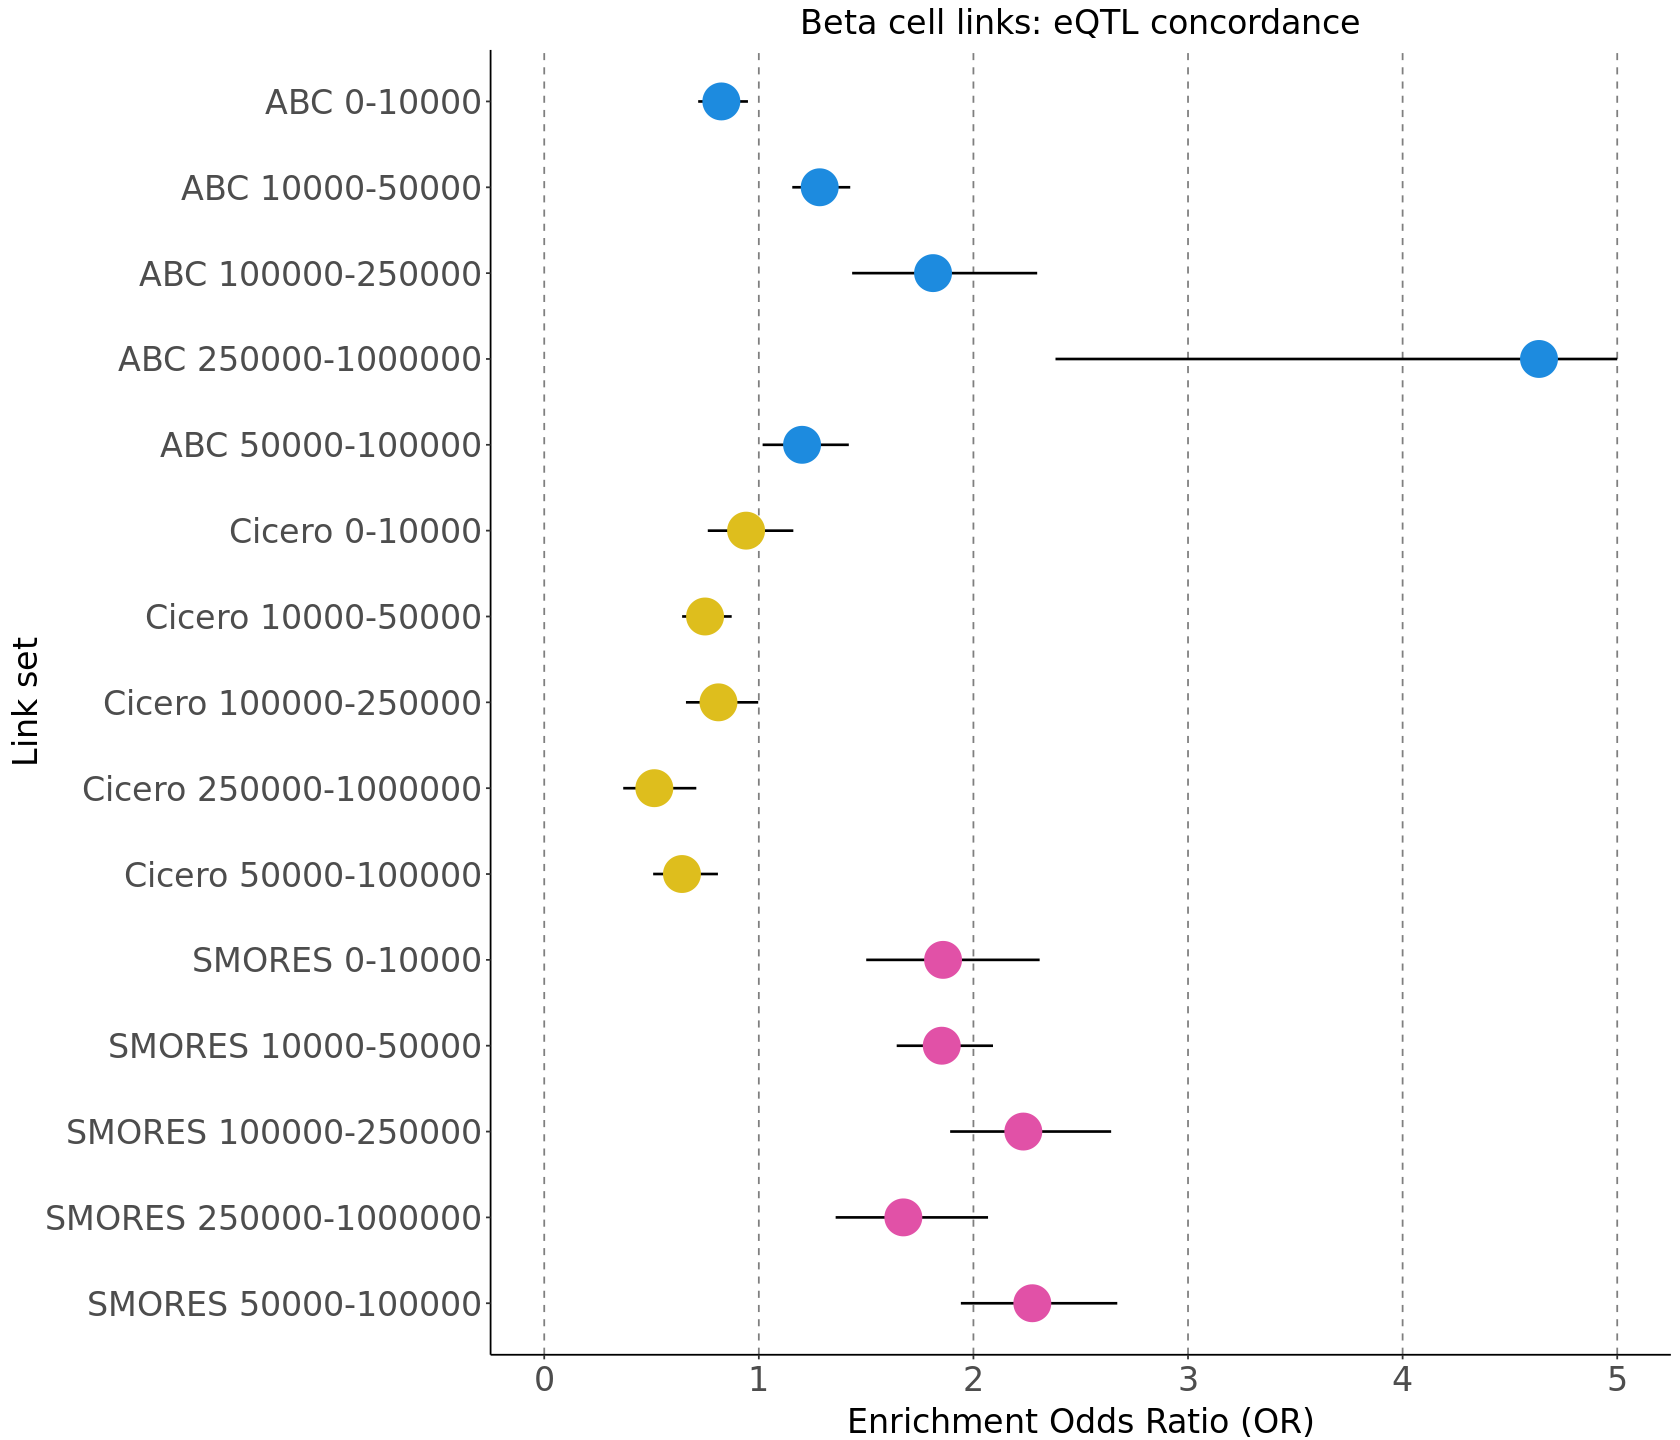

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


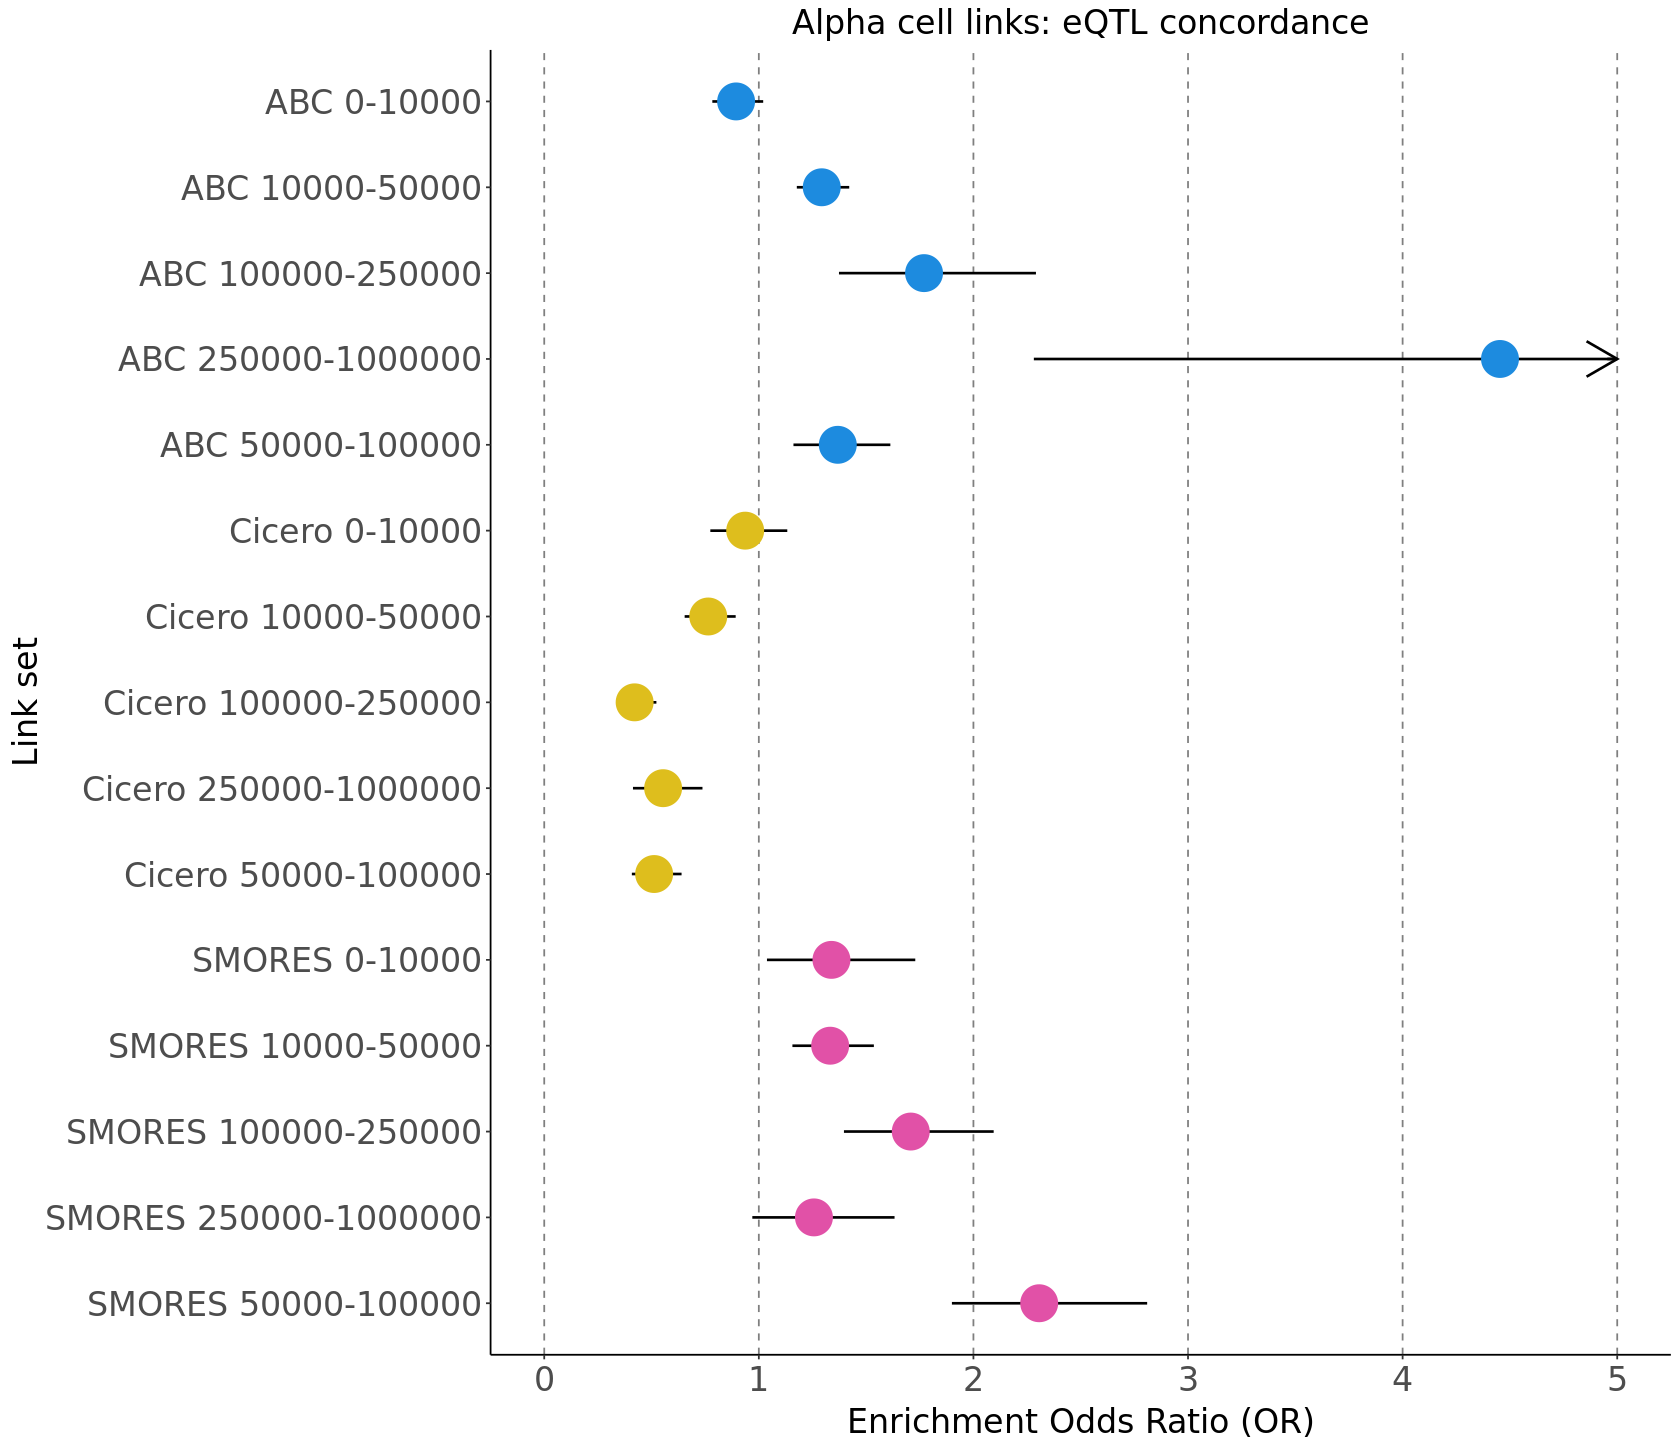

Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


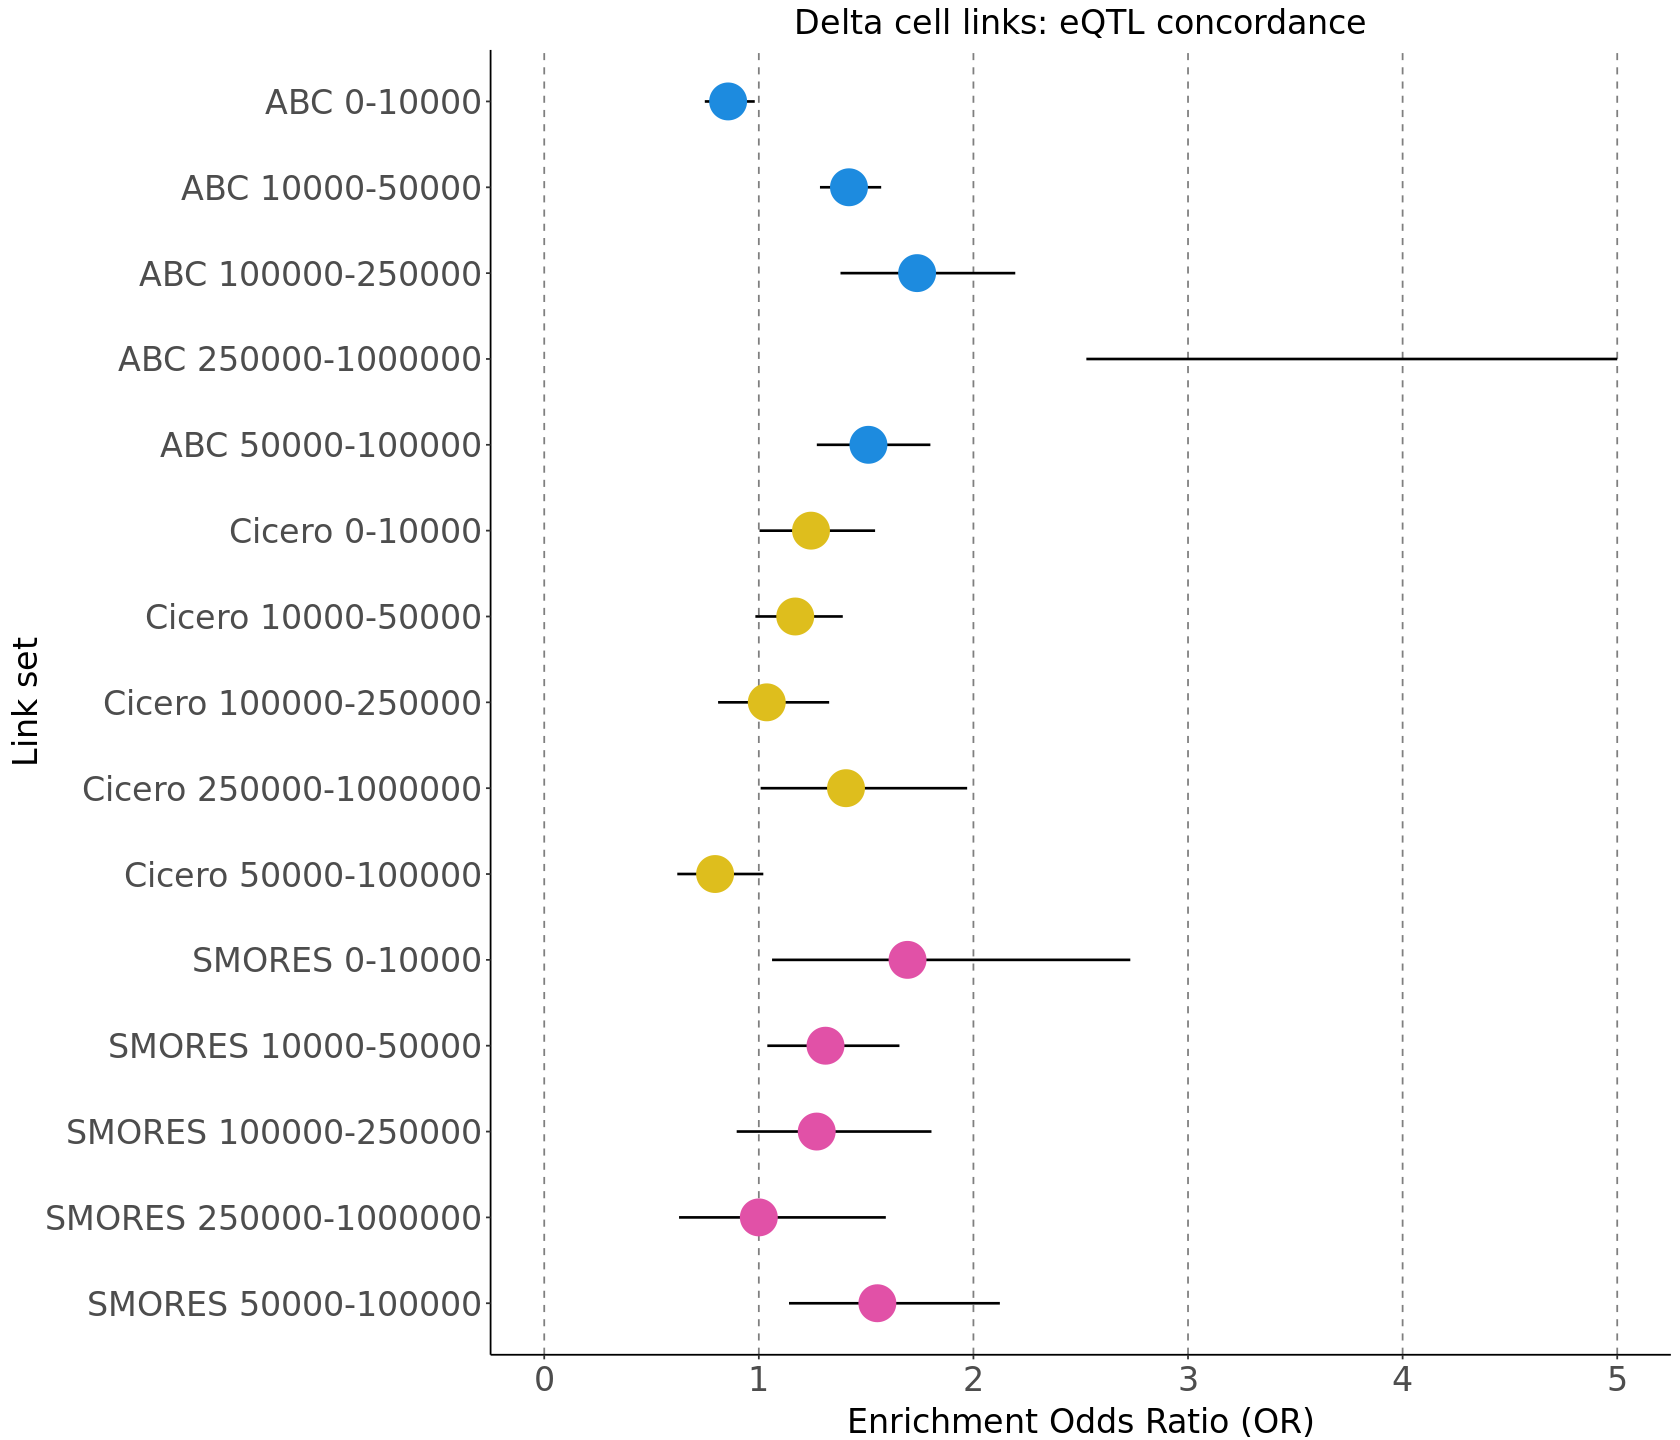

Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


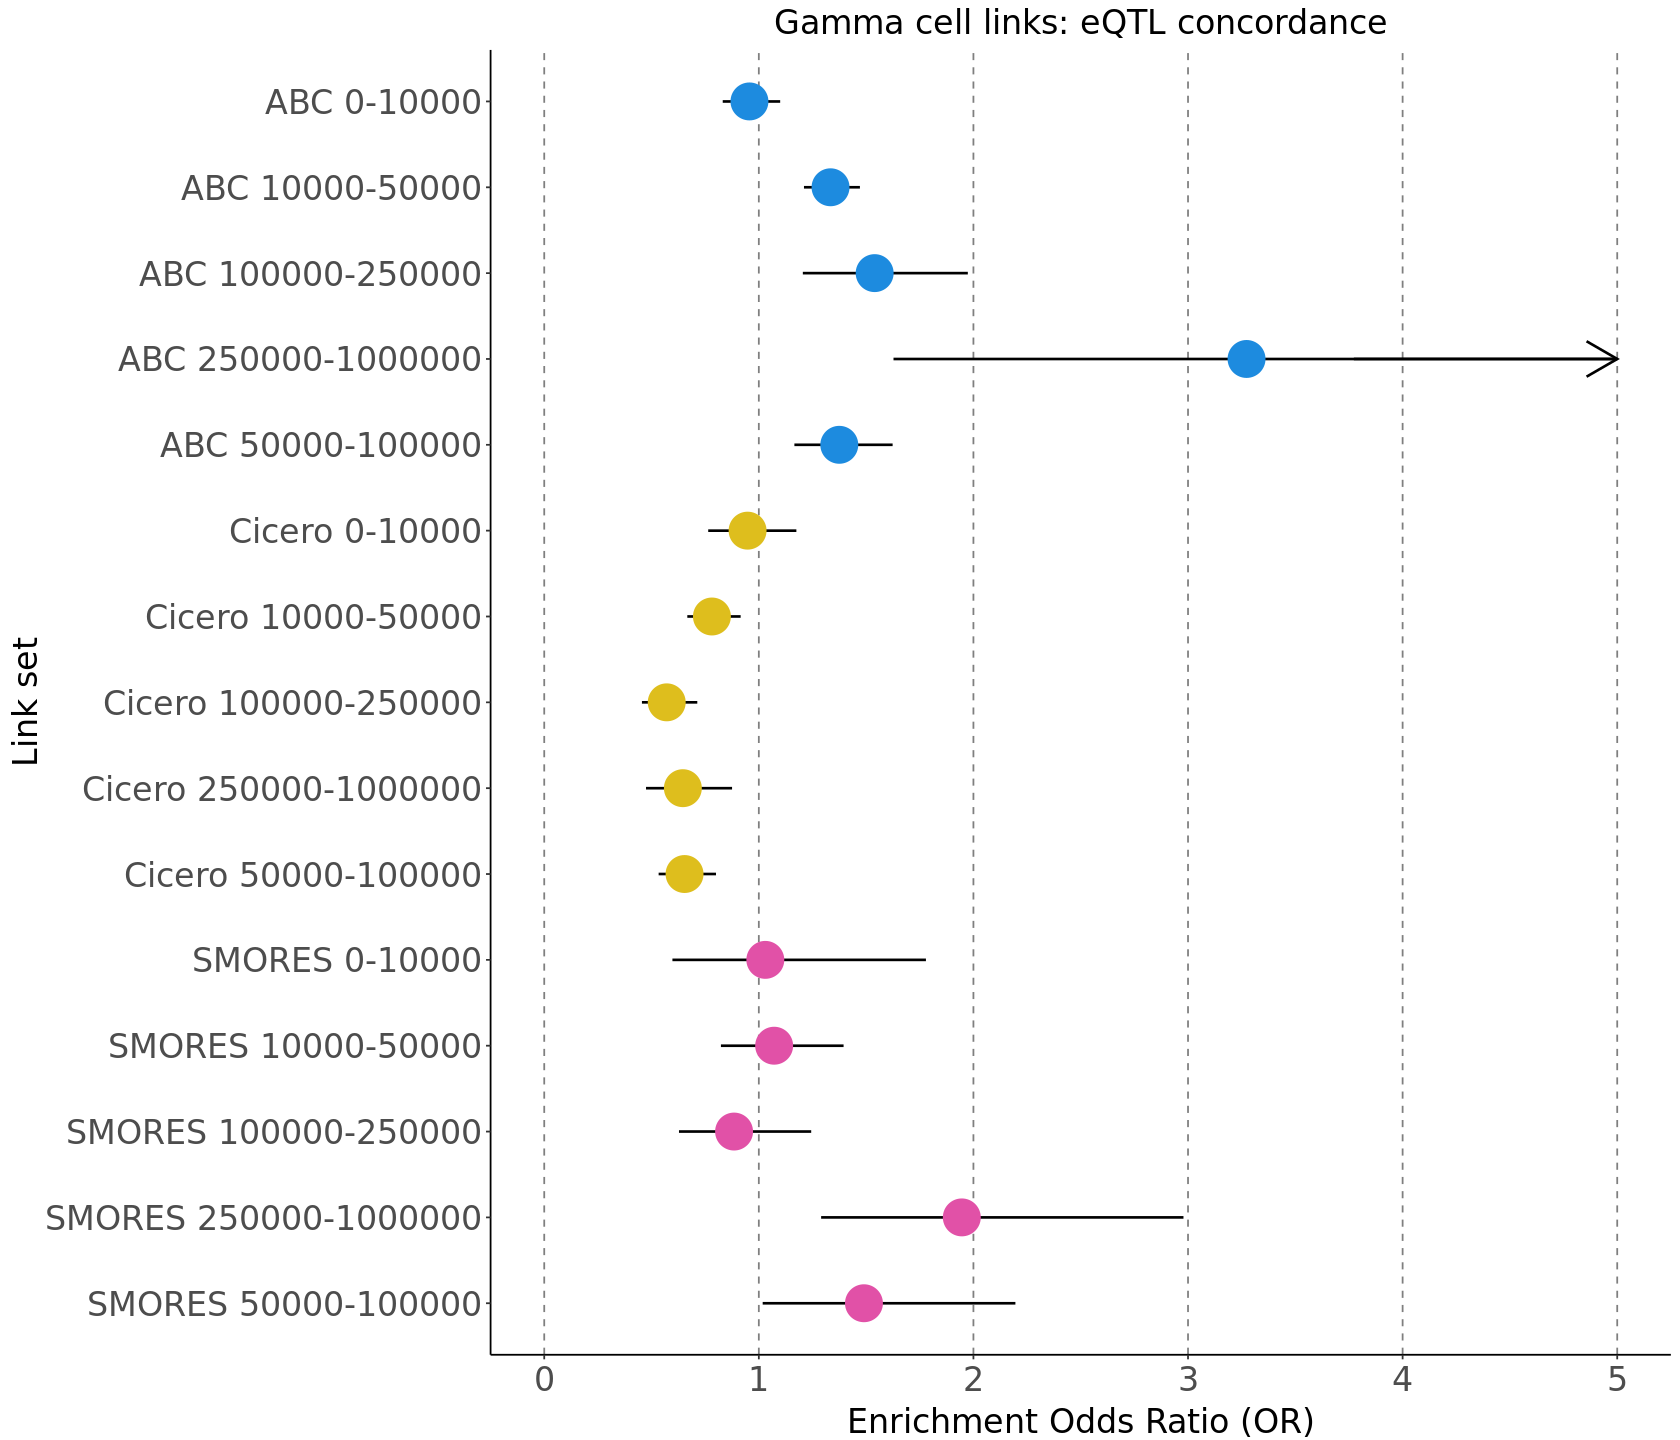

Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


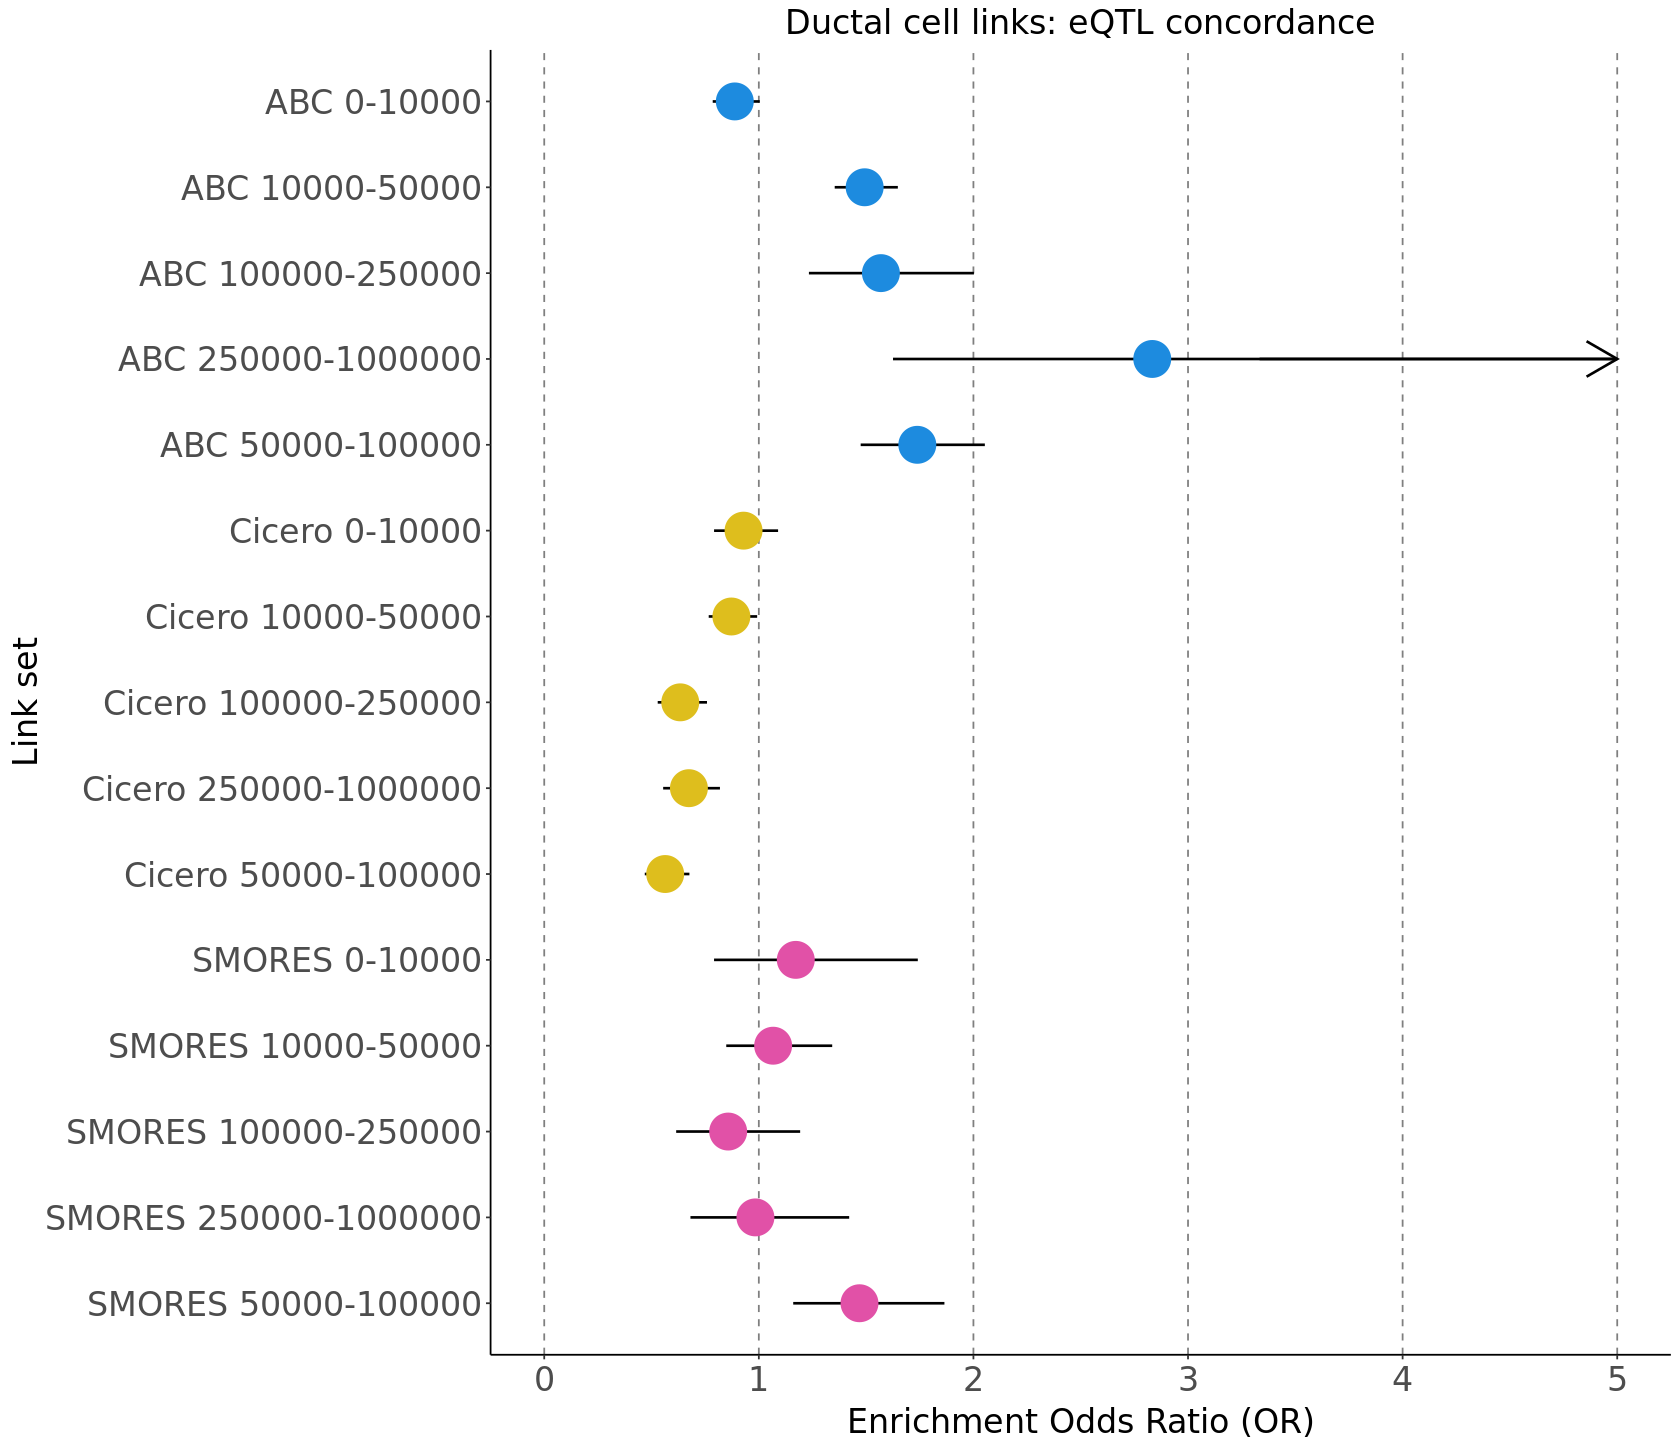

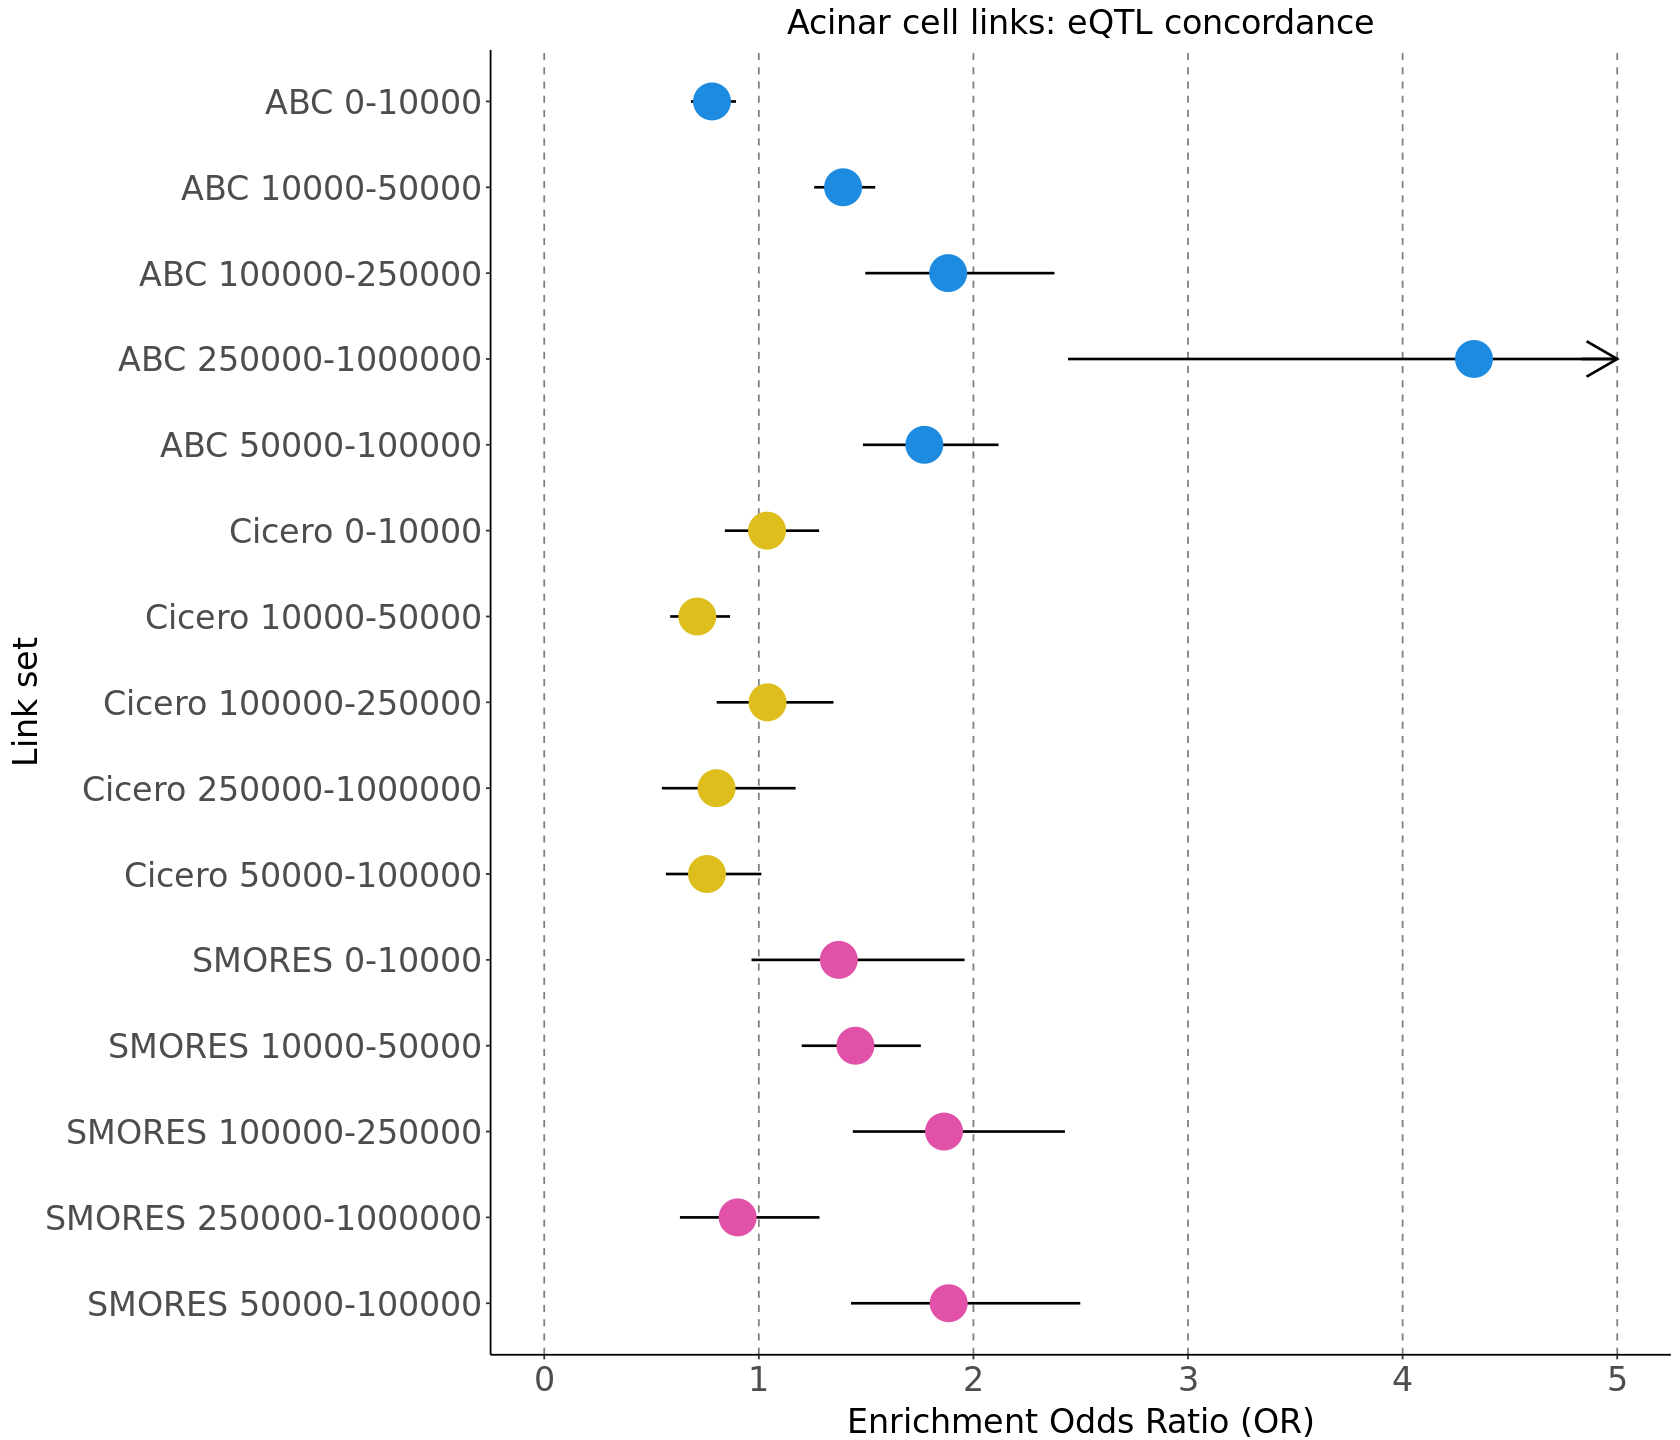

In [33]:
# Make plots by celltypes and/or methods
for (celltype in celltypes){
    results_fp <- file.path(fin_outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_dist_bin_comp.Fishers_enrichment.txt', celltype))
    title <- sprintf('%s cell links: eQTL concordance', str_to_title(celltype))
    plot_enrichment_comp_fin(results_fp, distance_bins, 5, c('SMORES', 'ABC', 'Cicero'), method_colors, title)
}

# 4. eQTL enrichment thresholded by distance (OVERLAP method sets)
Note: this is reusing all the functions from the previous section, so make sure those blocks have been run before running this part!
I'll also be using the method overlap link files and merged background file that I made in a previous notebook for comparison to the method overlap set links.

In [42]:
overlap_outdir <- file.path(outdir, 'cut_links_overlaps')
dir.create(overlap_outdir, showWarnings=FALSE)

## 4a. Write overlap sets to files for easy bedtools work

In [44]:
# Threshold all significant method links (get from overall df)
tic()
for (celltype in celltypes){
    #make celltype specific outdir
    ct_outdir <- file.path(overlap_outdir,paste0(celltype,'_sig'))
    dir.create(ct_outdir, showWarnings=FALSE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)

    #extract each overlap set (method_str) to a file
    for(set in link_sets){
        sig_links_cut <- subset(sig_links, method_str==set) %>% select(-c(hm_score,abc_score,cic_score,method_str))
        out_fp <- file.path(ct_outdir, sprintf('%s_links.bedpe', set))
        write.table(sig_links_cut, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)    
    }
}
toc()

42.532 sec elapsed


## 4b. Select for links that overlap an eQTL (in the cRE)

In [45]:
eqtl_dir <- file.path(outdir, 'method_overlap_overlaps')
eqtl_indir <- file.path(eqtl_dir, 'inputs')
dir.create(eqtl_indir, recursive=TRUE, showWarnings=FALSE)
bg_eqtl_indir <- file.path(eqtl_dir, 'inputs','bg')
dir.create(bg_eqtl_indir, recursive=TRUE, showWarnings=FALSE)

In [46]:
### Select for all links which have CREs that overlap an islet eQTL (for ANY input link bedpe)
### Save relevant eQTL information too (target gene, etc)
get_linkedCRE_eQTL_overlaps <- function(links_fp, eqtl_fp, out_fp){
    # Use bedtools intersect 
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb > %s', links_fp, eqtl_fp, out_fp)
    system(cmd)
    cmd2 <- sprintf('gzip %s', out_fp)
    system(cmd2)
}

In [47]:
# Loop through all overlap sets significant links and save out cell type sets which overlap 
tic()
for (celltype in celltypes){
    ct_indir <- file.path(overlap_outdir, paste0(celltype,'_sig'))
    ct_outdir <- file.path(eqtl_indir, paste0(celltype,'_sig'))
    dir.create(ct_outdir, showWarnings=FALSE)

    for (set in link_sets){
        signif_fp <- file.path(ct_indir, sprintf('%s_links.bedpe', set))
        out_fp <- file.path(ct_outdir,sprintf('%s_links.islet_eQTL_hg38_p0.00001.overlap.bed',set))
        get_linkedCRE_eQTL_overlaps(signif_fp, eqtl_fp, out_fp)
    }
}
toc()

114.559 sec elapsed


In [48]:
# Next loop through all overlap sets non-significant links and save out ones that overlap an eQTL
# There's only one bg file for this so don't need to loop through overlap sets
tic()
for (celltype in celltypes){
    bg_fp <- file.path(bg_dir, sprintf('%s_3method_merged_all_links.bedpe',celltype))
    out_fp <- file.path(bg_eqtl_indir,sprintf('%s_links.islet_eQTL_hg38_p0.00001.overlap.bed',celltype))
    get_linkedCRE_eQTL_overlaps(bg_fp, eqtl_fp, out_fp)
}
toc()

208.996 sec elapsed


## 4c. Compare concordance between links and eQTLs for comparable sets (signif and nonsignif)
Note: because I removed some cols from the SMORES outputs, we now should have bedpe files with identical cols! (CRE coods, gene coords, gene, score)

In [50]:
### Get the number of concordant eQTLs in linked CREs for significant and background links
### N dictates how many permutations to do (permutes whichever set is larger)

get_eqtl_concordance2 <- function(signif_links_fp, all_links, N=100){
    # Check if we have links to read in before proceeding
    if (file.size(signif_links_fp) == 0L){
        print(paste('No links in the file', signif_links_fp))
        return(c(NA,NA,NA,NA,NA,NA))
    } else if (dim(all_links)[1] == 0L){
        print('No links in the background file')
        return(c(NA,NA,NA,NA,NA,NA))        
    } else {
        # Read in files, noting if they have a header or not
        cols <- c('CRE_chr','CRE_start','CRE_end','gene_chr','gene_start','gene_end','link_gene','score',
                  'eqtl_chr','eqtl_start','eqtl_end','rsID','pvalue','effect','std_error','eqtl_gene')
        signif_links <- read.table(signif_links_fp, sep='\t', header=FALSE)
        colnames(signif_links) <- cols

        # Remove any significant links from the background (some bg files have them still) -- should I?
        signif_links$link <- paste(paste(signif_links[,1], signif_links[,2], signif_links[,3], sep="-"),
                                   paste(signif_links[,4], signif_links[,5], signif_links[,6], sep="-"), sep='_')
        all_links$link <- paste(paste(all_links[,1], all_links[,2], all_links[,3], sep="-"),
                                paste(all_links[,4], all_links[,5], all_links[,6], sep="-"), sep='_')
        all_links_cut <- all_links[!all_links$link %in% signif_links$link,]   

        # If # bg links is > # sig links, will subsample and calculate gene match many times
        if (dim(all_links_cut)[1] > dim(signif_links)[1]){
            bg_gene_matches <- unlist(mclapply(seq(1,N), get_links_eqtl_concordance, all_links_cut, dim(signif_links)[1], mc.cores=10))
            bg_gene_match <- round(mean(bg_gene_matches)) #need ints for stats

            # Also calculate gene matches for the significant peaks
            signif_links_fin <- signif_links
            signif_links_fin$gene_match <- unlist(apply(signif_links_fin, 1, compare_genes))
            sig_gene_match <- sum(signif_links_fin$gene_match)
            
            num_links <- dim(signif_links_fin)[1]

        # Otherwise permute subsampling for the significant links set
        } else {
            print(paste('Less background links than significant!', signif_links_fp))
            all_links_fin <- all_links_cut
            all_links_fin$gene_match <- unlist(apply(all_links_fin, 1, compare_genes))
            bg_gene_match <- sum(all_links_fin$gene_match)
            
            sig_gene_matches <- unlist(mclapply(seq(1,N), get_links_eqtl_concordance, signif_links, dim(all_links_cut)[1], mc.cores=10))
            sig_gene_match <- round(mean(sig_gene_matches))
            
            num_links <- dim(all_links_fin)[1]
        }

        # Organize outputs: # links, # links agree with eQTL, percent (for sig and all)
        outlist <- c(num_links, sig_gene_match, sig_gene_match/num_links, 
                    num_links, bg_gene_match, bg_gene_match/num_links)
        return(outlist)
    }    
}

In [51]:
### Function to get eQTL overlaps from each method (for one celltype) and then calculate enrichment of concordance
wrapper_get_eqtl_concordance2 <- function(celltype, indir, outdir, link_methods){
    ct_indir <- file.path(indir,paste0(celltype,'_sig')) 
    bg_indir <- file.path(indir,'bg')

    #read in bg file before loop so only have to once
    bg_fp <- file.path(bg_indir,sprintf('%s_links.islet_eQTL_hg38_p0.00001.overlap.bed.gz',celltype))
    all_links <- read.table(bg_fp, sep='\t', header=FALSE)
    colnames(all_links) <- c('CRE_chr','CRE_start','CRE_end','gene_chr','gene_start','gene_end','link_gene',
                             'eqtl_chr','eqtl_start','eqtl_end','rsID','pvalue','effect','std_error','eqtl_gene')
    
    overlap_df <- data.frame()
    # For each method go through the distance thresholded eQTL overlaps and calculate concordance metrics
    for (method in link_methods){
        sig_fp <- file.path(ct_indir,sprintf('%s_links.islet_eQTL_hg38_p0.00001.overlap.bed.gz',method))   
        results <- get_eqtl_concordance2(sig_fp, all_links)
        overlap_df <- rbind(overlap_df, results)
    }
    # Final modifications to the dataframe, then write out
    rownames(overlap_df) <- link_methods
    colnames(overlap_df) <- c('signif_links','signif_genes_match_eQTL','percent_signif',
                              'nonsignif_links','nonsignif_genes_match_eQTL','percent_nonsignif')
    out_fp <- file.path(outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_overlap_comp.txt', celltype))
    write.table(overlap_df, out_fp, sep='\t', row.names = TRUE, col.names = TRUE, quote=FALSE)
    return(overlap_df)
}

### Run functions to get concordance

In [52]:
fin_outdir <- file.path(eqtl_dir, 'outputs')
dir.create(fin_outdir, showWarnings=FALSE)

In [53]:
# run the celltype comparison function 
for (celltype in celltypes){
    ct_indir <- file.path(eqtl_indir, celltype)
    wrapper_get_eqtl_concordance2(celltype, eqtl_indir, fin_outdir, link_sets)
}

## 4d. Calculate enrichment

In [54]:
### Basic function to run Fisher's exact test for enrichment using an input data.table (2 x 2)
### Returns vector of (CI left side, odds ratio, CI right side)
test_eqtl_enrichment <- function(df_row){
    # Set up data table (2 x 2) for test
    data <- data.frame('links_match'=c(as.numeric(df_row[['signif_genes_match_eQTL']]), as.numeric(df_row[['nonsignif_genes_match_eQTL']])),
                        'total_links'=as.numeric(c(df_row[['signif_links']]), as.numeric(df_row[['nonsignif_links']])),
                        row.names=c('signif_links','nonsignif_links'))
    data_fin <- as.matrix(data)
    test <- fisher.test(data_fin)
    vector <- c(test$conf.int[1], test$estimate, test$conf.int[2], test$p.value)
    return(vector)
}

In [55]:
### Function to read in 3 method compare connections output files and run Fisher's exact test for enrichment
### for a given celltype, then create a Forest plot comparing the odds ratio and CIs
### Modified to deal with link set names (which have _ in them oops)
calculate_all_eqtl_enrichment2 <- function(fp, outdir, celltype){
    # Read in eQTL concordance overlap dataframe (it's celltype specific, already has all methods)
    df <- read.table(fp, sep='\t', row.names=1, header=TRUE)
    
    # Remove any rows with NA values (no links overlapped an eQTL)
    df <- df[!is.na(df[,1]),]
    df$id <- row.names(df)
    rownames(df) <- seq(1, dim(df)[1])
    
    # Run Fisher's exact test for each row in each df_fin
    tests <- apply(df, 1, test_eqtl_enrichment)
    test_results <- as.data.frame(t(tests))
    colnames(test_results) <- c('CI_L','odds_ratio','CI_R','pval')
    
    # Add in other information
    test_results$id <- df$id
    
    # Write this out to a file!
    out_fp <- file.path(outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_overlap_comp.Fishers_enrichment.txt',celltype))
    write.table(test_results, out_fp, sep='\t', col.names=TRUE, row.names=FALSE, quote=FALSE)
}

In [56]:
# Combine all results and run Fischer's enrichment test
for (celltype in celltypes){
    fp <- file.path(fin_outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_overlap_comp.txt', celltype))
    calculate_all_eqtl_enrichment2(fp, fin_outdir, celltype)
}

## 4e. Make plots

In [57]:
### dedicated plotting function
plot_enrichment_comp_fin2 <- function(fp, link_sets, xmax, colors, plot_title){
    # Read in table of Fisher's exact test odd's ratios and CIs
    data <- read.table(fp, sep='\t', header = TRUE)
    row.names(data) <- data$id
    
    # Add in color info and factor IDs based on links sets
    data_cut_sort <- data
    data_cut_sort$color <- colors[data_cut_sort$id] 
    data_cut_sort$id <- factor(data_cut_sort$id, levels=link_sets)
    
    # Set any values outside of xmax to the limits (also record which values exceed the limits)
    past_xmax <- row.names(data_cut_sort[data_cut_sort$CI_R > xmax,])
    data_cut_sort[past_xmax, 'CI_R'] <- xmax
    or_past_xmax <- row.names(data_cut_sort[data_cut_sort$odds_ratio > xmax,])
    
    # Prepare input vectors for arrows 
    data_cut_sort$max_arrow_L <- NA 
    data_cut_sort[past_xmax, 'max_arrow_L'] <- data_cut_sort[past_xmax,'odds_ratio'] + 0.5
    data_cut_sort$max_arrow_R <- NA
    data_cut_sort[past_xmax, 'max_arrow_R'] <- xmax
    if (length(or_past_xmax) > 0){
        print(or_past_xmax)
        data_cut_sort[or_past_xmax, 'max_arrow_L'] <- NA
        data_cut_sort[or_past_xmax, 'max_arrow_R'] <- NA
    }
    
    # Prepare strings for y-labels (get rid of underscore in rownames)
    y_labels <- rev(gsub('_', ' ', data_cut_sort$id))
        
    # Make a forest plot with the subsetted data
    options(repr.plot.width = 14, repr.plot.height = 12)
    theme_set(
        theme_classic())

    p1 <- ggplot(data=data_cut_sort, aes(x=odds_ratio, y=id, group=celltype, fill=color)) + 
            geom_vline(xintercept=seq(0, xmax, 1), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=CI_L, xmax=CI_R), size=0.75) + 
            geom_point(aes(x=odds_ratio), size=10, color=colors[data_cut_sort$id], group=celltype) + 
            scale_color_manual() + xlim(0,xmax) + 
            scale_y_discrete(labels=y_labels) + 
            xlab('Enrichment Odds Ratio (OR)') + ylab('Link set') + labs(title=plot_title) + 
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5),
                  legend.position = "none")
    p1$data$id <- factor(x = p1$data$id, levels=rev(data_cut_sort$id))
    if(length(past_xmax) > 0){
        p1 <- p1 + geom_segment(aes(x=max_arrow_L, xend=max_arrow_R, y=row.names(data_cut_sort), yend=row.names(data_cut_sort)),
                                lineend = 'butt', linejoin='mitre', size = 0.75, 
                                 arrow = arrow(length = unit(0.03, "npc")))
    }
    
    print(p1)
}

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


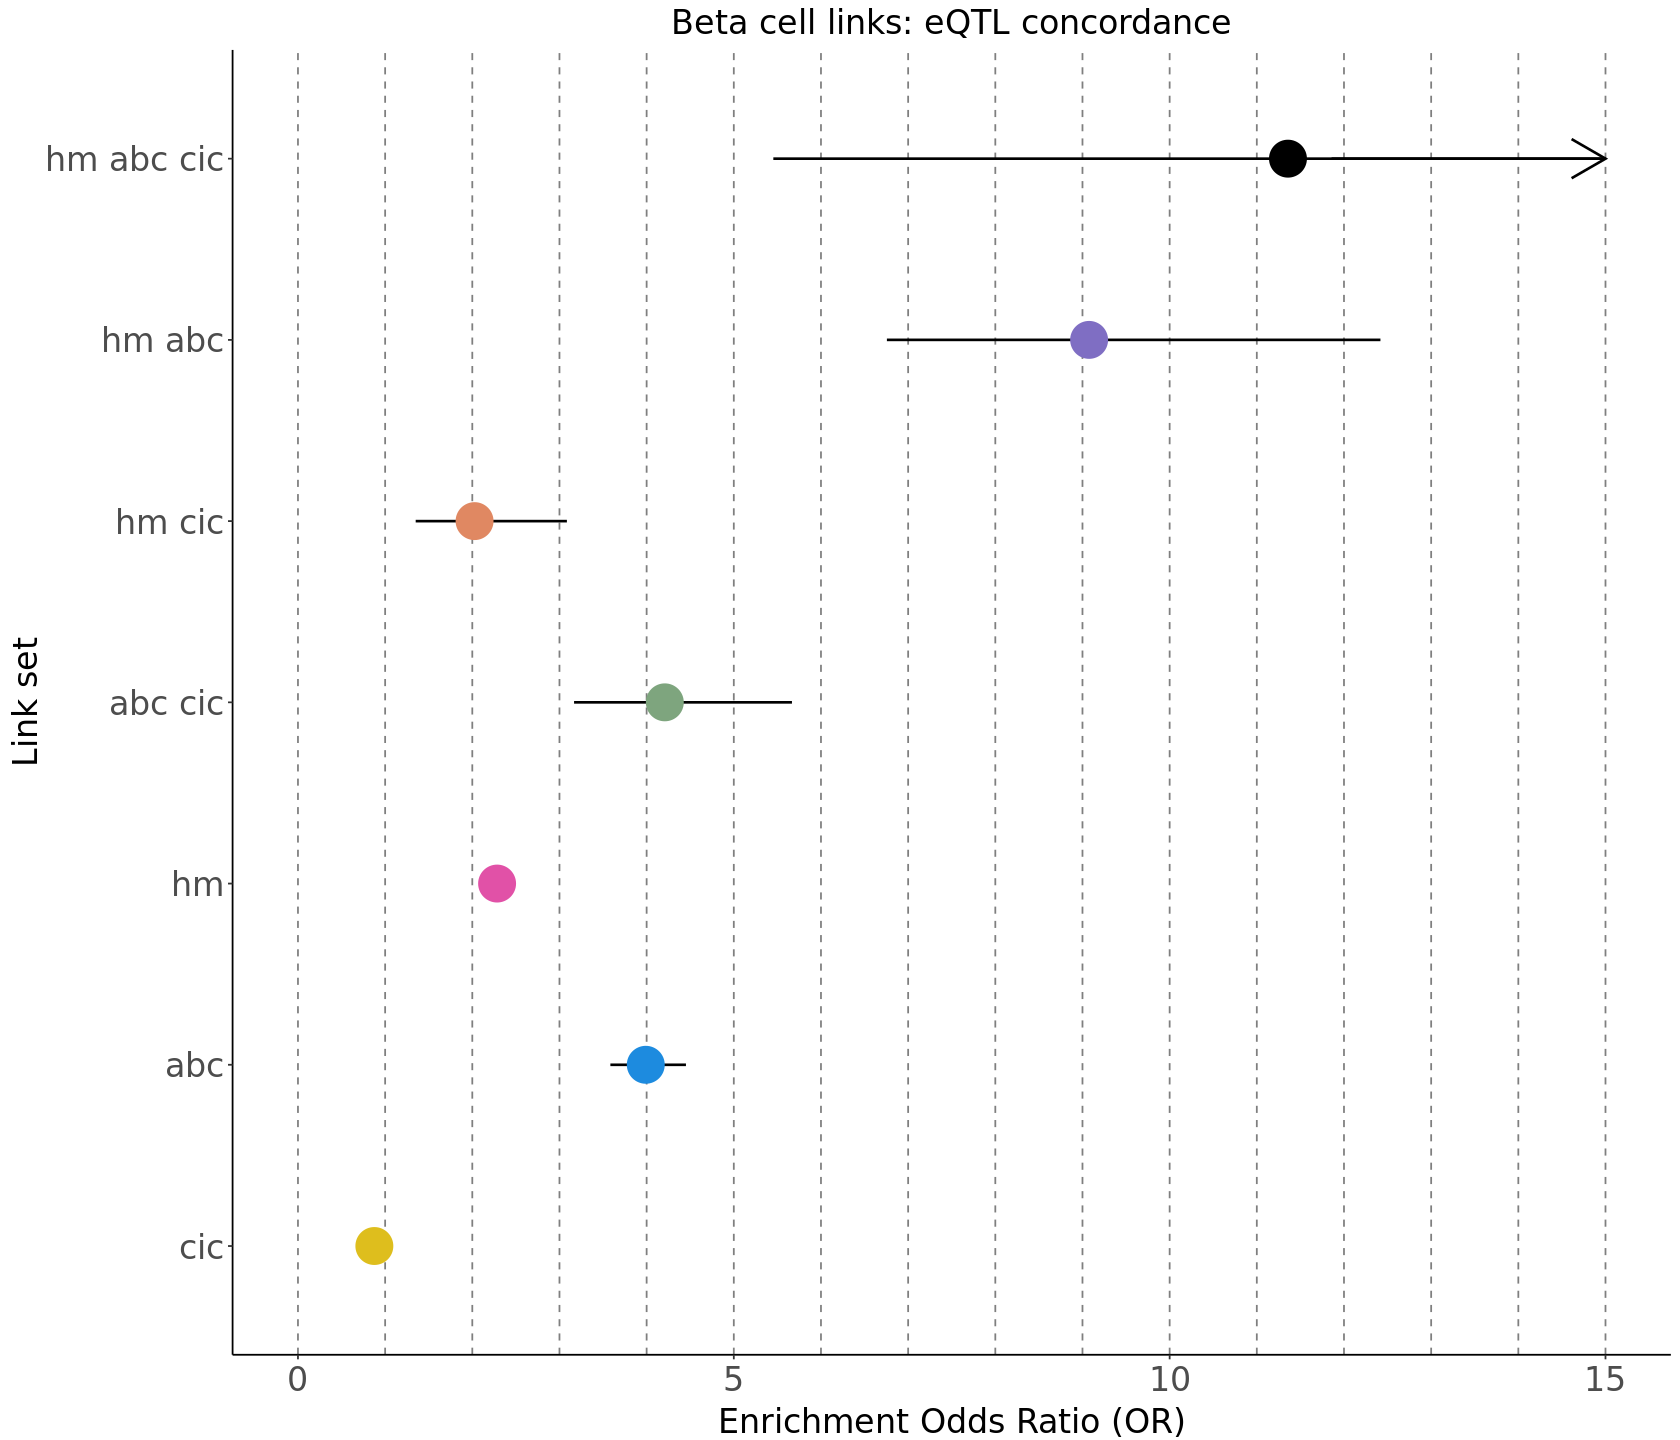

[1] "hm_abc_cic"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


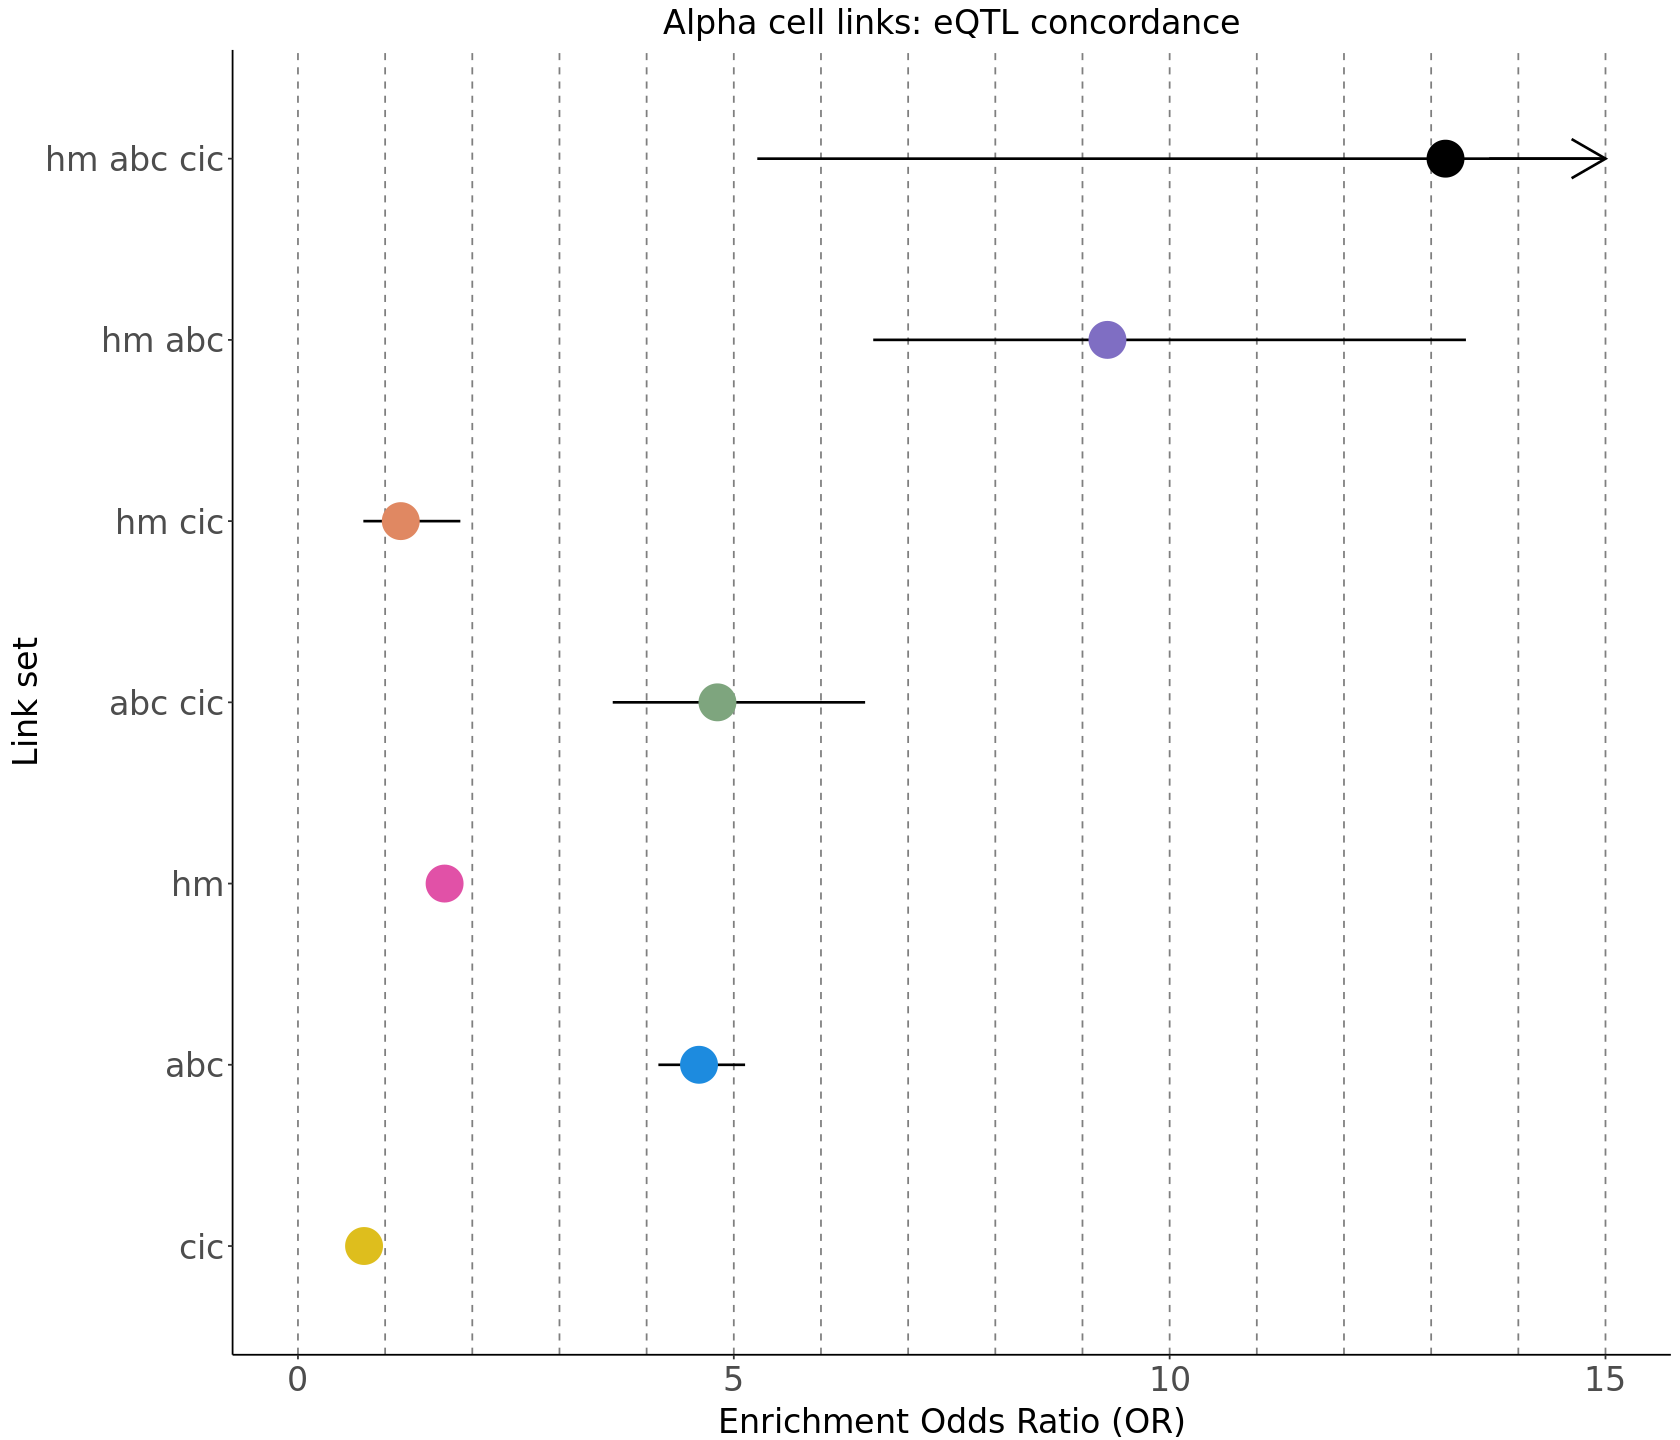

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


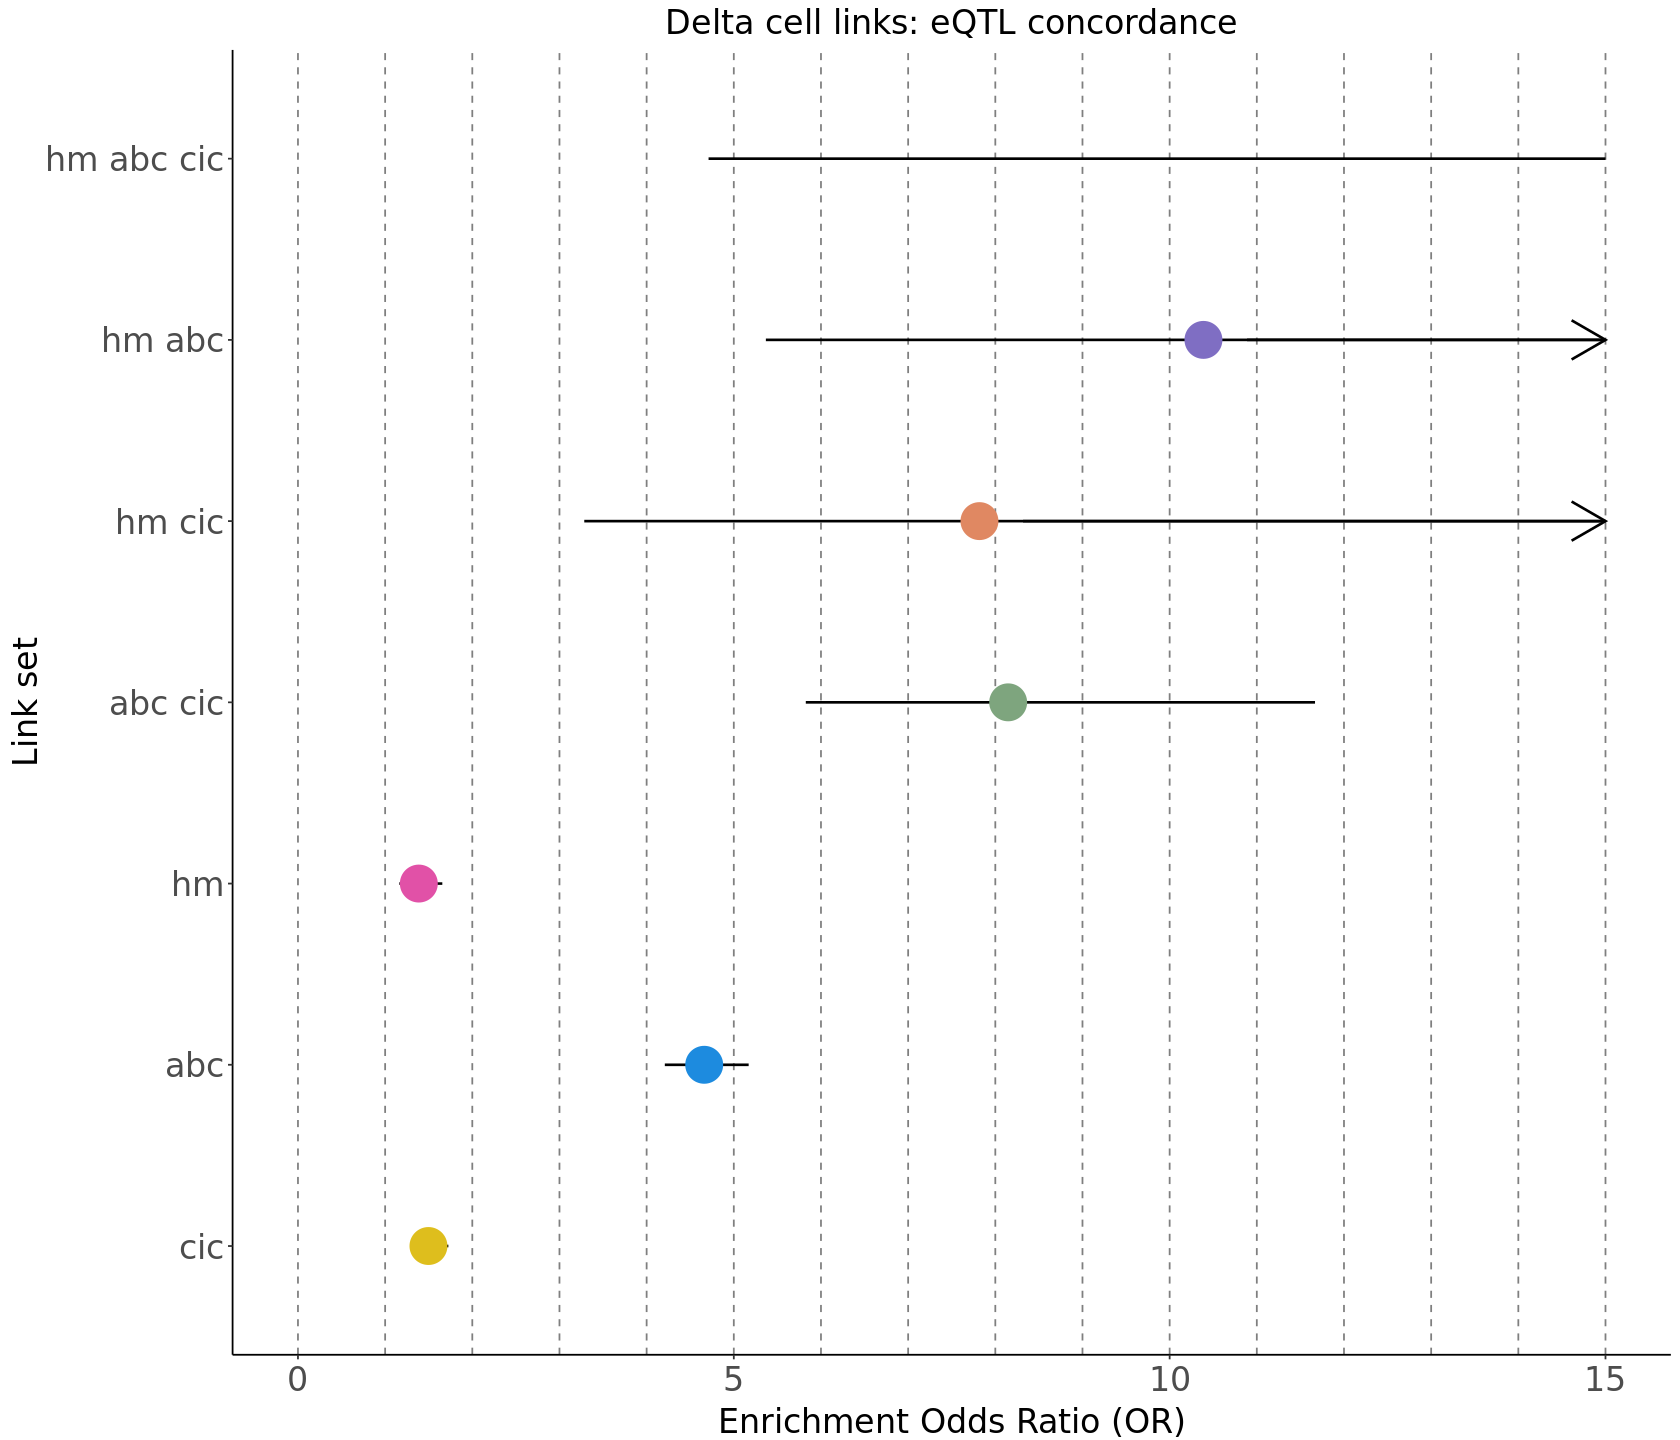

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


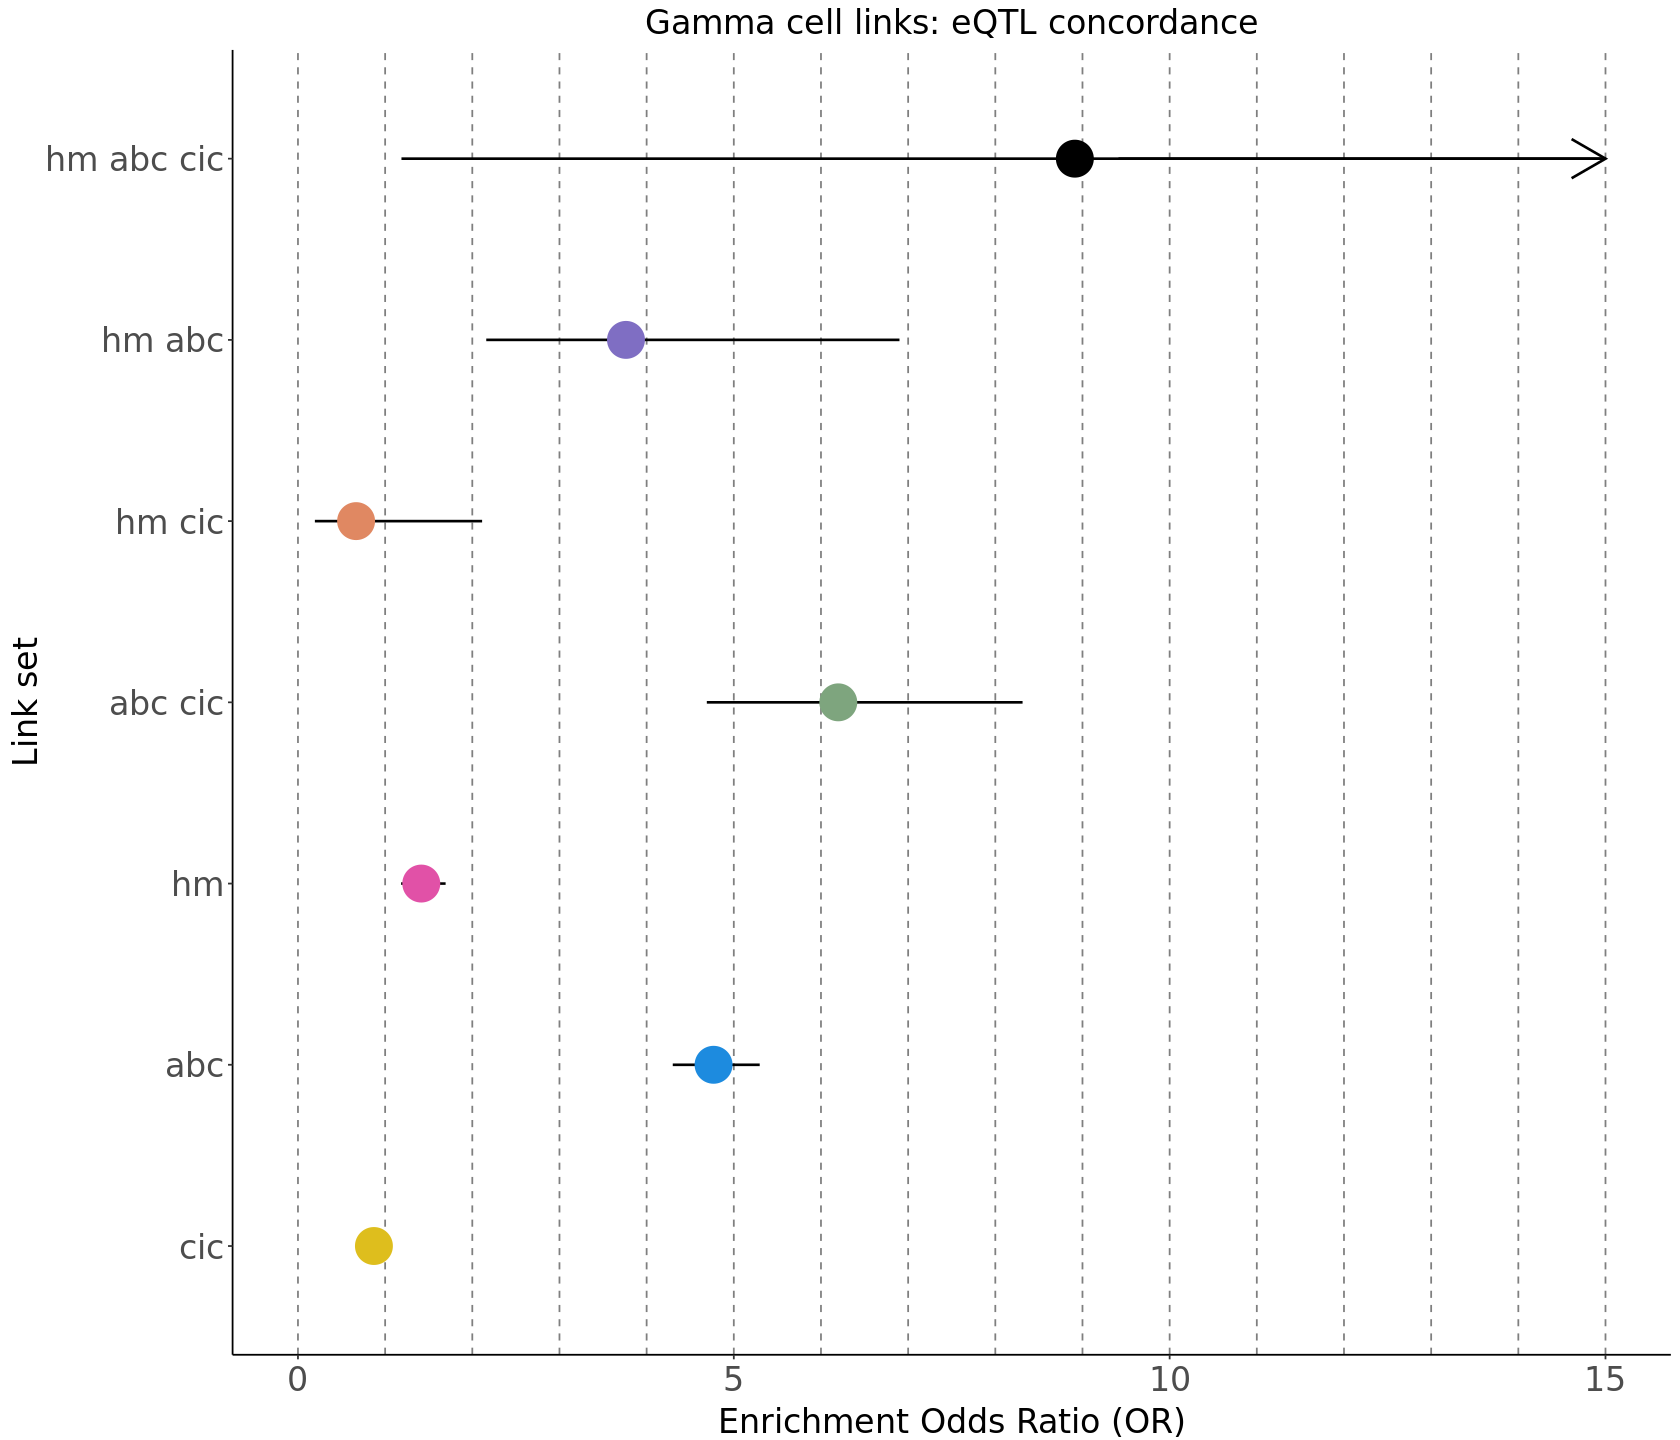

Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


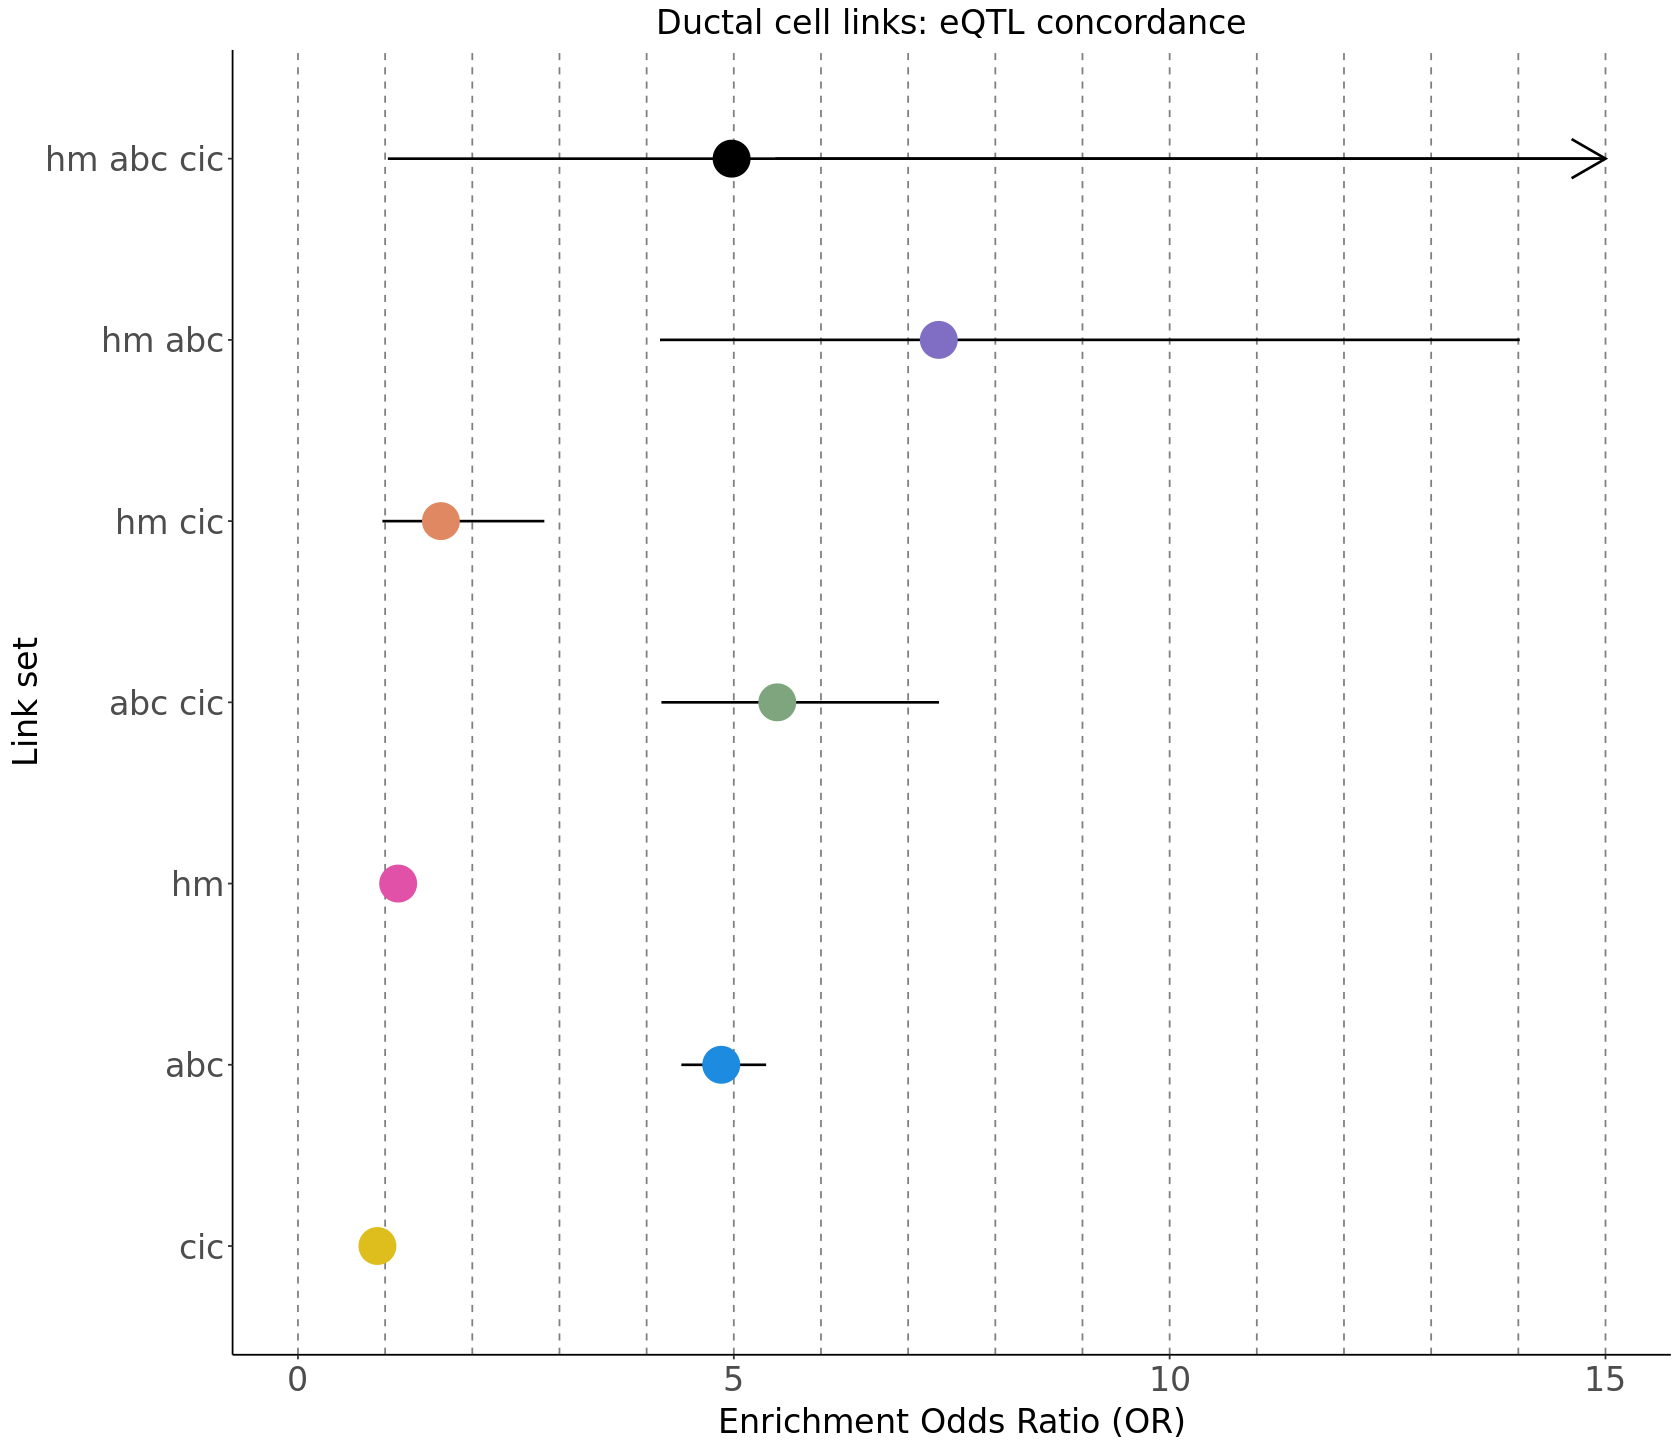

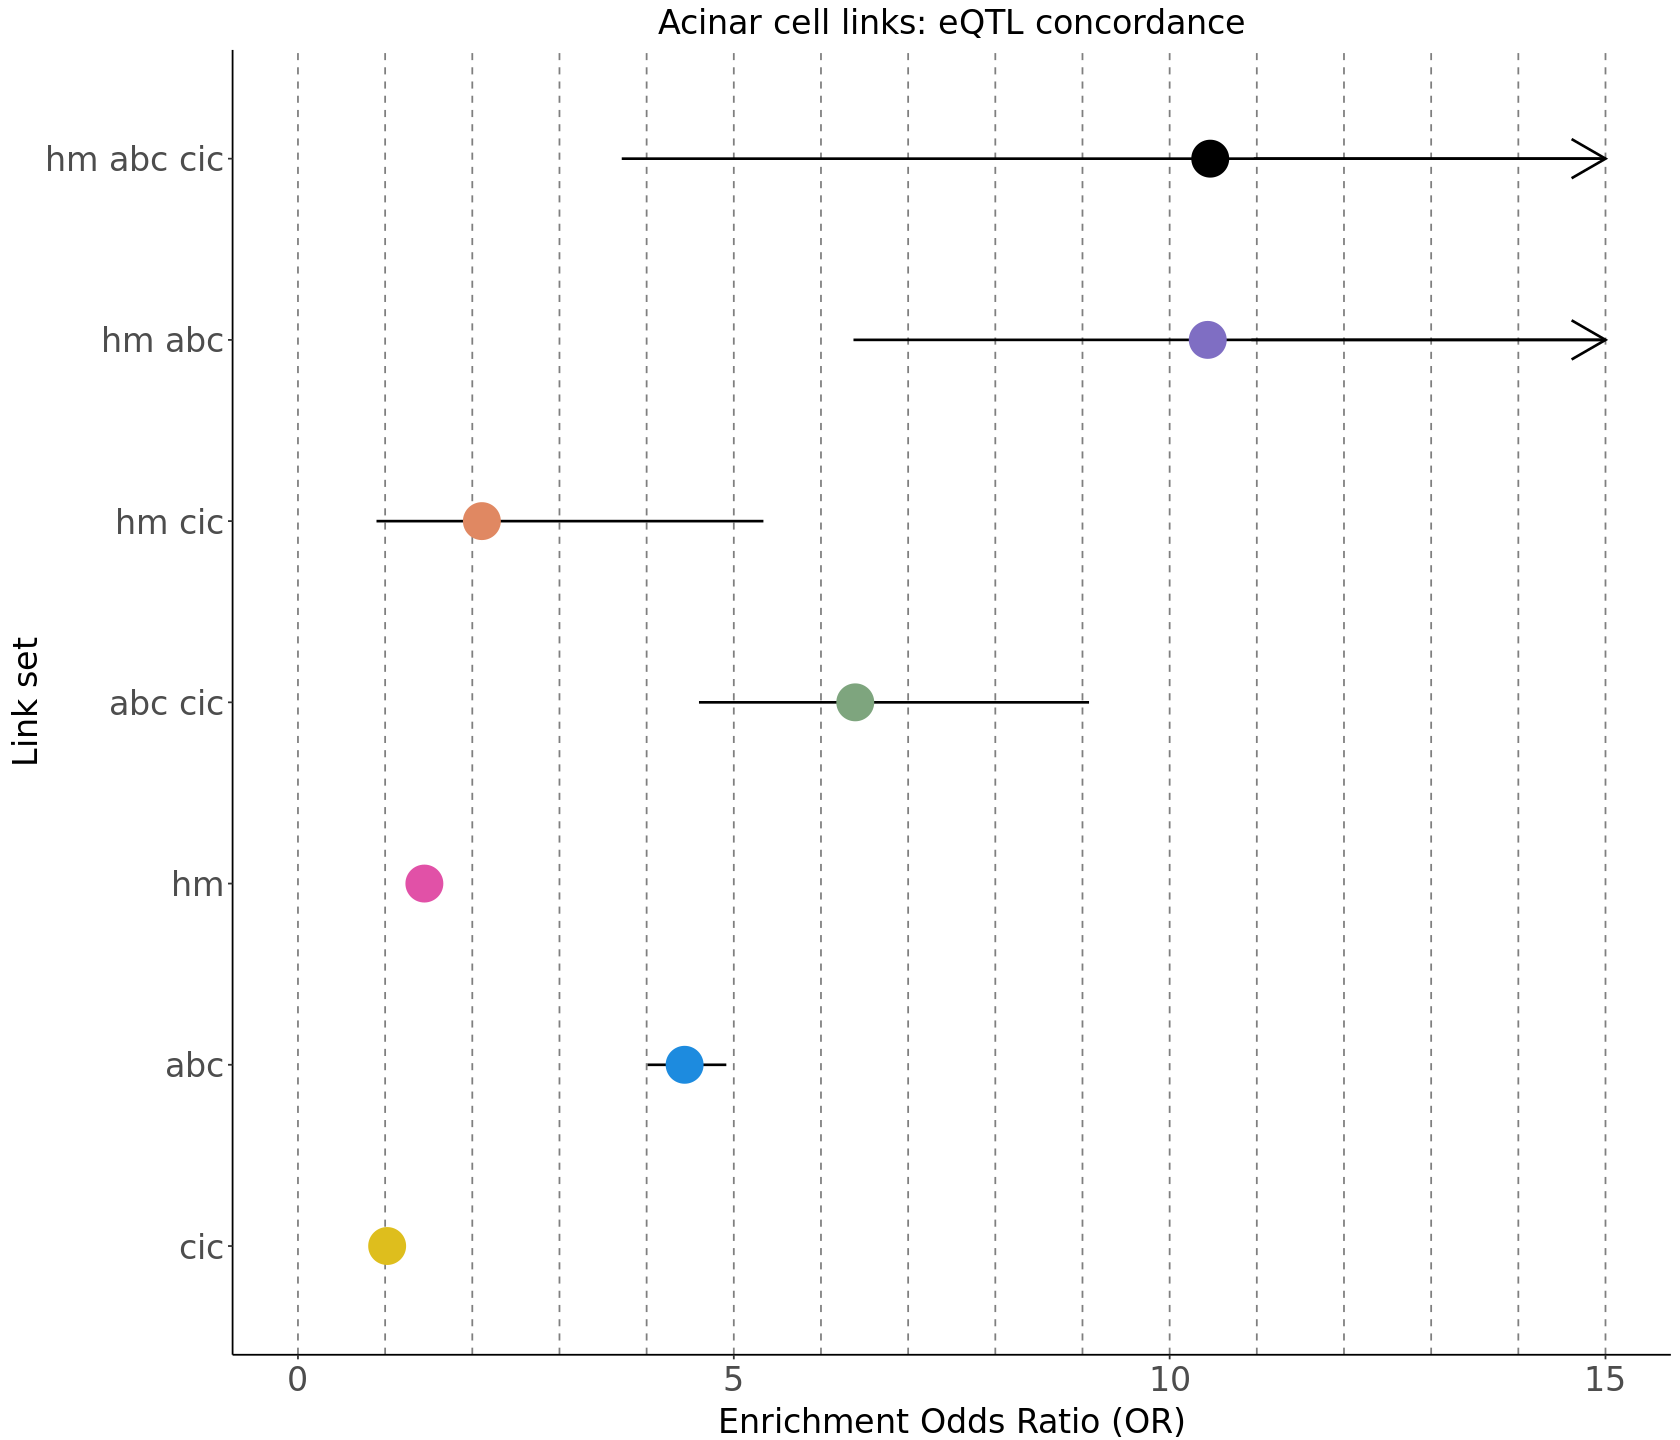

In [58]:
# Make plots by celltypes and/or methods
for (celltype in celltypes){
    results_fp <- file.path(fin_outdir, sprintf('%s_eQTL_overlap_concordance.link_methods_overlap_comp.Fishers_enrichment.txt',celltype))
    title <- sprintf('%s cell links: eQTL concordance', str_to_title(celltype))
    plot_enrichment_comp_fin2(results_fp, link_sets, 15, overlap_colors, title)
}

# 5. Delete intermediates from both directories

In [59]:
eqtl_indir1 <- file.path(outdir, 'distance_binned_overlaps', 'inputs')
eqtl_indir2 <- file.path(outdir, 'method_overlap_overlaps', 'inputs')

In [60]:
cmd1 <- sprintf('rm -r %s/*', eqtl_indir1)
system(cmd1)

cmd2 <- sprintf('rm -r %s/*', eqtl_indir2)
system(cmd2)

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  splines   stats4    grid      stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3   pheatmap_1.0.12      cicero_1.12.0       
 [4] Gviz_1.38.4          GenomicRanges_1.46.1 GenomeInfoDb_1.30.1 
 [7] IRanges_2.28.0       S4Vectors_0.32.4     monocle_2.22.0      
[10] DDRTree_0.1.5